In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import ROOT


plt.rcParams["figure.figsize"] = (10, 8)


Welcome to JupyROOT 6.27/01


In [2]:
def get_theta(eta):
    return 2*np.arctan(np.exp(-eta))
def get_eta(theta):
    return -np.log(np.tan(theta/2))
from scipy.optimize import curve_fit

In [3]:
#first get the Moliere radius

['MCParticles.PDG', 'MCParticles.generatorStatus', 'MCParticles.simulatorStatus', 'MCParticles.charge', 'MCParticles.time', 'MCParticles.mass', 'MCParticles.vertex.x', 'MCParticles.vertex.y', 'MCParticles.vertex.z', 'MCParticles.endpoint.x', 'MCParticles.endpoint.y', 'MCParticles.endpoint.z', 'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z', 'MCParticles.momentumAtEndpoint.x', 'MCParticles.momentumAtEndpoint.y', 'MCParticles.momentumAtEndpoint.z', 'MCParticles.spin.x', 'MCParticles.spin.y', 'MCParticles.spin.z', 'MCParticles.colorFlow.a', 'MCParticles.colorFlow.b', 'MCParticles.parents_begin', 'MCParticles.parents_end', 'MCParticles.daughters_begin', 'MCParticles.daughters_end', 'MCParticles#0.index', 'MCParticles#0.collectionID', 'MCParticles#1.index', 'MCParticles#1.collectionID', 'EventHeader.eventNumber', 'EventHeader.runNumber', 'EventHeader.timeStamp', 'EventHeader.weight', 'BackwardsEcalInsertHits.cellID', 'BackwardsEcalInsertHits.energy', 'BackwardsE

<ipython-input-4-879043b2a6dc>:28: RuntimeWarning: invalid value encountered in float_scalars
  x0=np.sum(x*w)/np.sum(w)
<ipython-input-4-879043b2a6dc>:29: RuntimeWarning: invalid value encountered in float_scalars
  y0=np.sum(y*w)/np.sum(w)
<ipython-input-4-879043b2a6dc>:30: RuntimeWarning: invalid value encountered in float_scalars
  z0=np.sum(z*w)/np.sum(w)


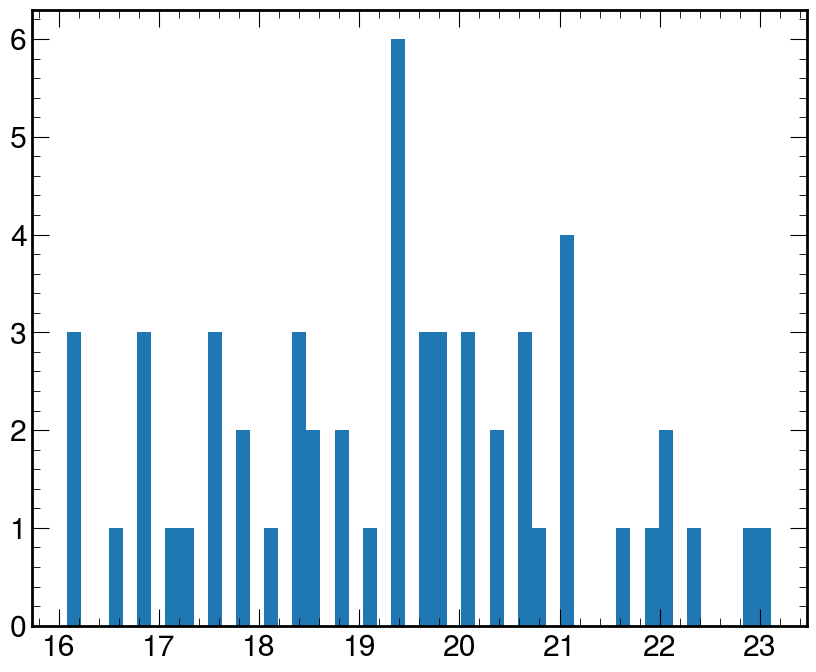

moliere radius=19.3+-0.2 mm


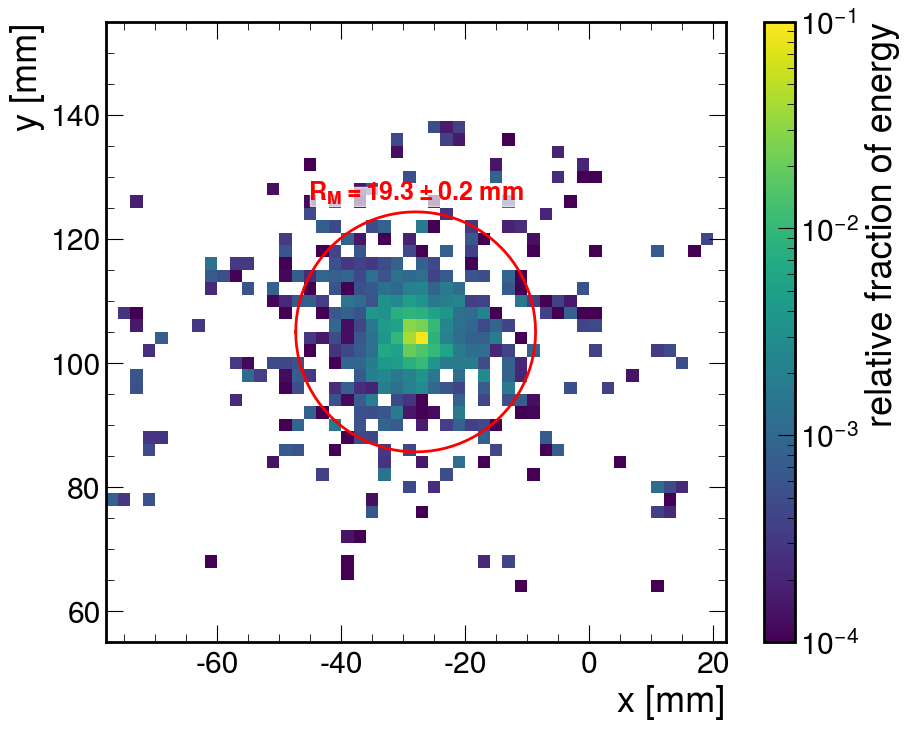

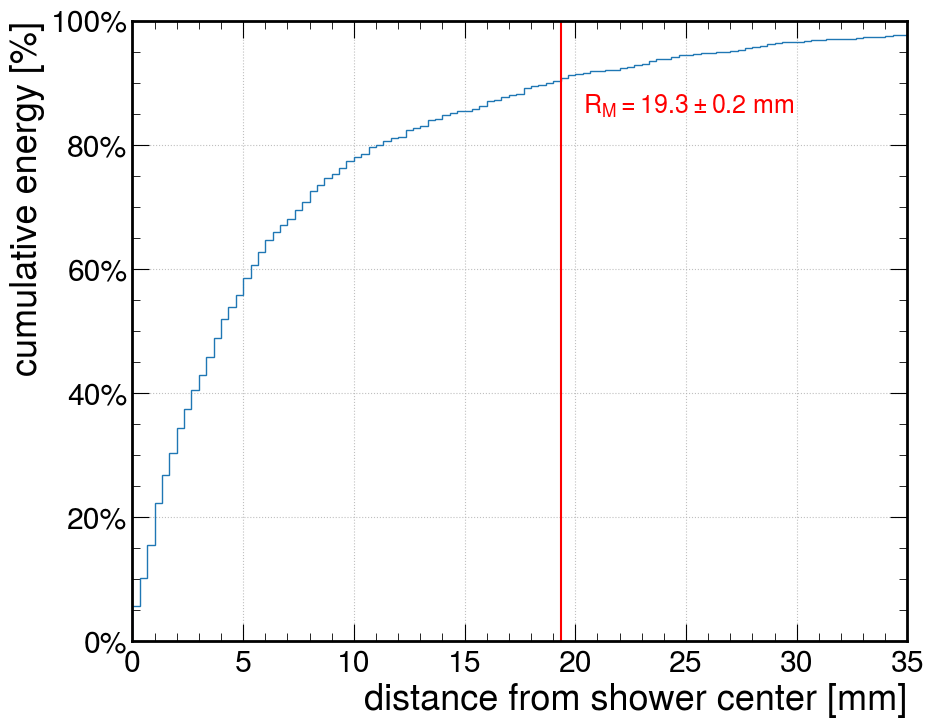

In [4]:
import uproot as ur
events = ur.open('for_RM_nohole_1mm_RO/insert_sim_e-_18GeV_theta_178-178deg.edm4hep.root:events')
arrays_sim = events.arrays()

# events_mu = ur.open('for_RM_nohole_1mm_RO/insert_sim_mu-_18GeV_theta_178-178deg.edm4hep.root:events')
# plt.hist(events.arrays()['BackwardsEcalInsertHits.energy'][0,:],bins=50)
# plt.show()
print(arrays_sim.fields)
rMs=[]
for event in range(100):#len(arrays_sim)):
    #x=arrays_sim['BackwardsEcalInsertHitsContributions.stepPosition.x'][event,:]
    #y=arrays_sim['BackwardsEcalInsertHitsContributions.stepPosition.y'][event,:]
    #E=arrays_sim['BackwardsEcalInsertHitsContributions.energy'][event,:]
    x=arrays_sim['BackwardsEcalInsertHits.position.x'][event,:]
    y=arrays_sim['BackwardsEcalInsertHits.position.y'][event,:]
    z=arrays_sim['BackwardsEcalInsertHits.position.z'][event,:]
    E=arrays_sim['BackwardsEcalInsertHits.energy'][event,:]
    #print(x, y, E)
    
    Etot=np.sum(E)
    E=E*(E>Etot*1e-7)
    Etot=np.sum(E)
    
    if(Etot==0): continue
    
    w=(4+np.log((E+.0000001)/Etot))
    w=(w>0)*w
    x0=np.sum(x*w)/np.sum(w)
    y0=np.sum(y*w)/np.sum(w)
    z0=np.sum(z*w)/np.sum(w)
    
    #account for the fact that the electrons don't hit the calorimeter head on, 
    #but rather at a small angle:
    x0c=x0*z/z0
    y0c=y0*z/z0
    
    r=np.hypot(x-x0c, y-y0c)
    #print(max(r))
    found=False
    for rM in np.linspace(0, 50, 200):
        if np.sum(E*(r<rM))/Etot>.9:
            found=True
            break
    if found:
        rMs.append(rM)
    
rM=np.mean(rMs)
plt.hist(rMs,bins=50);
plt.show()
drM=np.std(rMs)/np.sqrt(len(rMs))
print(f"moliere radius={rM:.1f}+-{drM:.1f} mm")
plt.subplots(1,1, figsize=(10, 10*249/309))
from matplotlib.colors import LogNorm

h=plt.hist2d(x,y, bins=50, range=((x0-50, x0+50), (y0-50, y0+50)),weights=E, norm=LogNorm(vmin=1e-4, vmax=1e-1))

cb=plt.colorbar(h[3])
cb.set_label("relative fraction of energy")


ph=np.linspace(-np.pi, np.pi, 101)
plt.plot(x0+rM*np.cos(ph), y0+rM*np.sin(ph), color='r',zorder=100, ls='-', lw=2)
plt.text(x0, y0+rM*1.1, f"$R_M={rM:.1f}\\pm {drM:.1f}$ mm", ha='center', color='red', fontsize=18, zorder=11, weight='bold')
plt.gca().add_patch(mpl.patches.Rectangle((x0-17, y0+rM+1),34, 3, color='w', alpha=0.7, zorder=10))
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.savefig("images/xy_Moliere.pdf")
plt.show()

plt.subplots(1,1, figsize=(10, 10*249/309))

plt.hist(r, bins=300, density=True, histtype='step',weights=E,
                           cumulative=True, range=(0,100))
plt.xlim(0,35)
plt.ylim(0,1)
plt.text(rM+1, .85, f"$R_M={rM:.1f}\\pm {drM:.1f}$ mm", color='red', fontsize=18, zorder=11)
plt.axvline(rM, color='r')
plt.ylabel("cumulative energy [%]")
plt.xlabel("distance from shower center [mm]")
import matplotlib.ticker as mtick

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.grid()
plt.savefig("images/shower_distance_from_center.pdf")
plt.show()


In [5]:
#next determine the resolutions on everything

In [6]:
def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

In [7]:
(-176+178.875)//.125+1

24.0

In [8]:
import uproot as ur
arrays={}
for E in 0.9, 2, 5, 10, 18:
    theta=178
    #events = ur.open(f'add_flange/insert_reco_e-_{E}GeV_theta_{theta}-{theta}deg.edm4hep.root:events')
    events = ur.open(f'06212023/insert_reco_e-_{E}GeV_theta_{theta}-{theta}deg.edm4hep.root:events')
    arrays[(E,theta)] = events.arrays()

thetas="177.125 177.250 177.375 177.500 177.625 177.750 177.875 178.000 178.125 178.250 178.375 178.500 178.625 178.750 178.775".split()\
       +"178.800 178.825 178.850 178.875 178.900 178.925 178.950 178.975 179.000 179.025 179.050 179.075 179.100".split()
thetas=[float(theta) for theta in thetas]
for theta in thetas:
    E=5
    events = ur.open(f'06212023/insert_reco_e-_{E}GeV_theta_{theta:.3f}-{theta:.3f}deg.edm4hep.root:events')
    arrays[(E,theta)] = events.arrays()


In [9]:
print(np.max(arrays[(18,178)]['BackwardsEcalInsertHitsReco.energy']))

0.07873535


In [10]:
import os
try:
    os.mkdir("images")
except:
    pass

In [11]:
#CALICE data
csvString="""
x,y
0.177578,2.50831
0.184753,2.59382
0.226009,3.04988
0.260090,3.53444
0.292377,3.70546
0.356951,4.44656
0.502242,6.21378
0.708520,9.03563
0.175785,2.82185
0.182960,2.87886
0.226009,3.33492
0.260090,3.84798
0.290583,4.01900
0.355157,4.76010
0.500448,6.52732
0.708520,9.32067"""
from io import StringIO
csvStringIO = StringIO(csvString)
df = pd.read_csv(csvStringIO, sep=",")
E=list(1/(df.x[:len(df)//2])**2)
res=list(df.y[:len(df)//2])
dres=list(df.y[len(df)//2:]-res)
df_CALICE= pd.DataFrame({"E": E, "res":res, "dres":dres})
print(df_CALICE.E)

0    31.711857
1    29.296585
2    19.577108
3    14.782663
4    11.698053
5     7.848430
6     3.964368
7     1.992030
Name: E, dtype: float64


In [12]:
# spreadXs=[]
# spreadYs=[]
# key=(5,178)
# for event in range(10):
#     E=arrays[key]['BackwardsEcalInsertHitsReco.energy'][event,:]
#     x=arrays[key]['BackwardsEcalInsertHitsReco.position.x'][event,:]
#     y=arrays[key]['BackwardsEcalInsertHitsReco.position.y'][event,:]
#     z=arrays[key]['BackwardsEcalInsertHitsReco.position.z'][event,:]
#     z2=sorted(z)[1]
#     isXlayer=(arrays[key]['BackwardsEcalInsertHitsReco.dimension.x'][event,:]<20)
#     isYlayer=(arrays[key]['BackwardsEcalInsertHitsReco.dimension.y'][event,:]<20)
    
#     x0=np.average(E*x*isXlayer, weights=E*isXlayer)
#     y0=np.average(E*y*isYlayer, weights=E*isYlayer)
#     plt.hist((x-x0), weights=E*isXlayer, bins=160, range=(-800,800))
#     plt.show()
# #plt.hist(spreadXs,histtype='step')
# #plt.show()
# #plt.hist(spreadYs, histtype='step')
# #plt.show()

In [13]:
# spreadXs=[]
# spreadYs=[]
# key=(5,178)
# for event in range(len(arrays[key])):
#     E=arrays[key]['BackwardsEcalInsertHitsReco.energy'][event,:]
#     x=arrays[key]['BackwardsEcalInsertHitsReco.position.x'][event,:]
#     y=arrays[key]['BackwardsEcalInsertHitsReco.position.y'][event,:]
#     isXlayer=arrays[key]['BackwardsEcalInsertHitsReco.dimension.x'][event,:]<20
#     isYlayer=arrays[key]['BackwardsEcalInsertHitsReco.dimension.y'][event,:]<20
#     if sum(isXlayer)== 0:
#         continue
#     x0=np.average(E*x*isXlayer, weights=E*isXlayer)
#     y0=np.average(E*y*isYlayer, weights=E*isYlayer)
#     spreadXs.append(np.sqrt(np.sum((x-x0)**2*E*isXlayer)/np.sum(E*isXlayer)))
#     spreadYs.append(np.sqrt(np.sum((y-y0)**2*E*isYlayer)/np.sum(E*isYlayer)))
# plt.hist(spreadXs,histtype='step')
# plt.show()
# plt.hist(spreadYs, histtype='step')
# plt.show()

sampling fraction=0.0325
chi2=4.040, ndof=7, pval=0.775


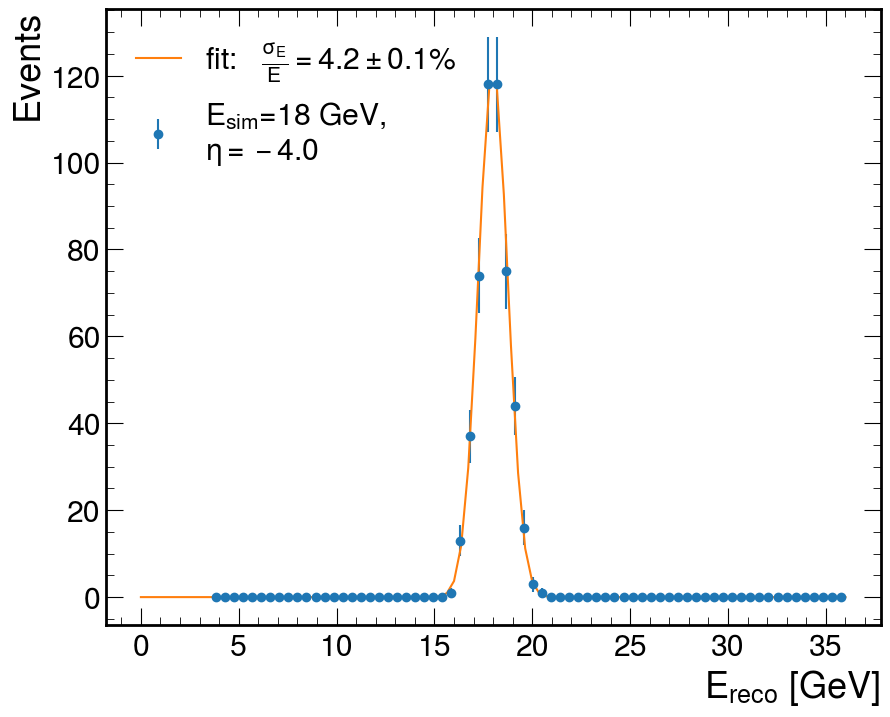

sampling fraction=0.0325
chi2=23.366, ndof=15, pval=0.0767


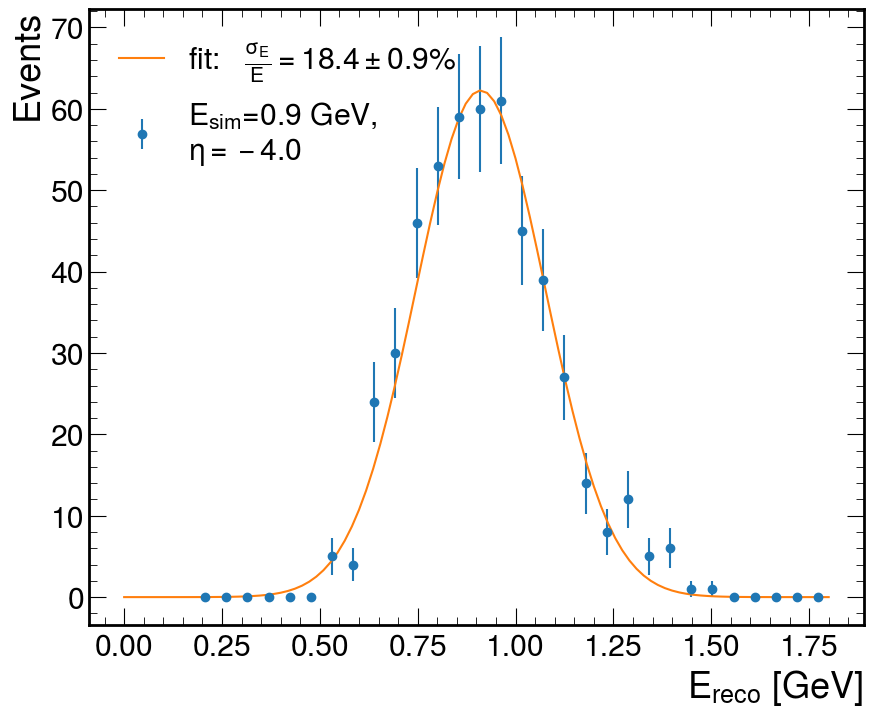

sampling fraction=0.0325
chi2=2.868, ndof=8, pval=0.942


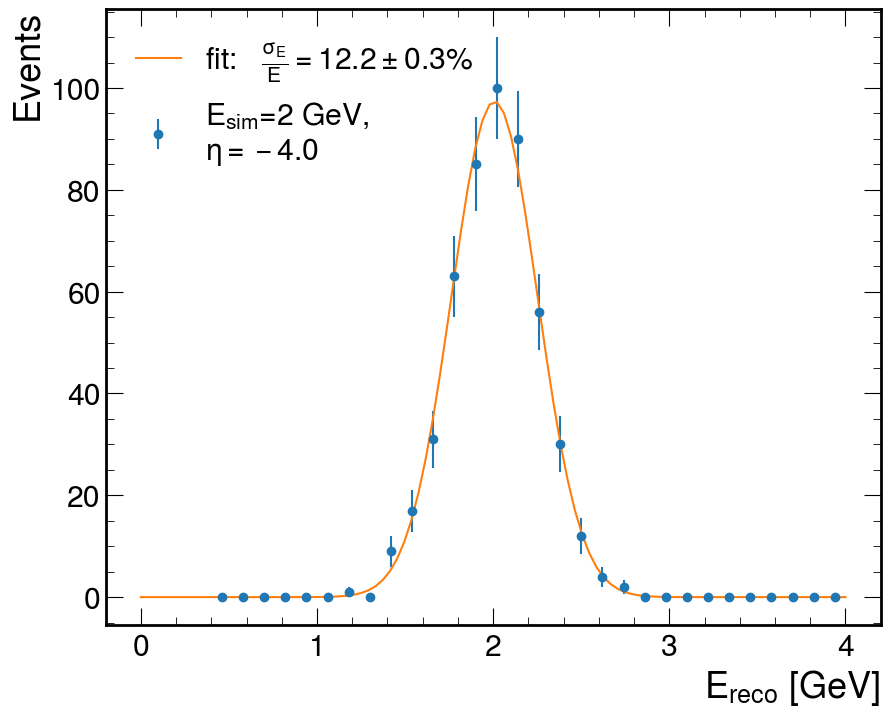

sampling fraction=0.0325
chi2=8.540, ndof=11, pval=0.664


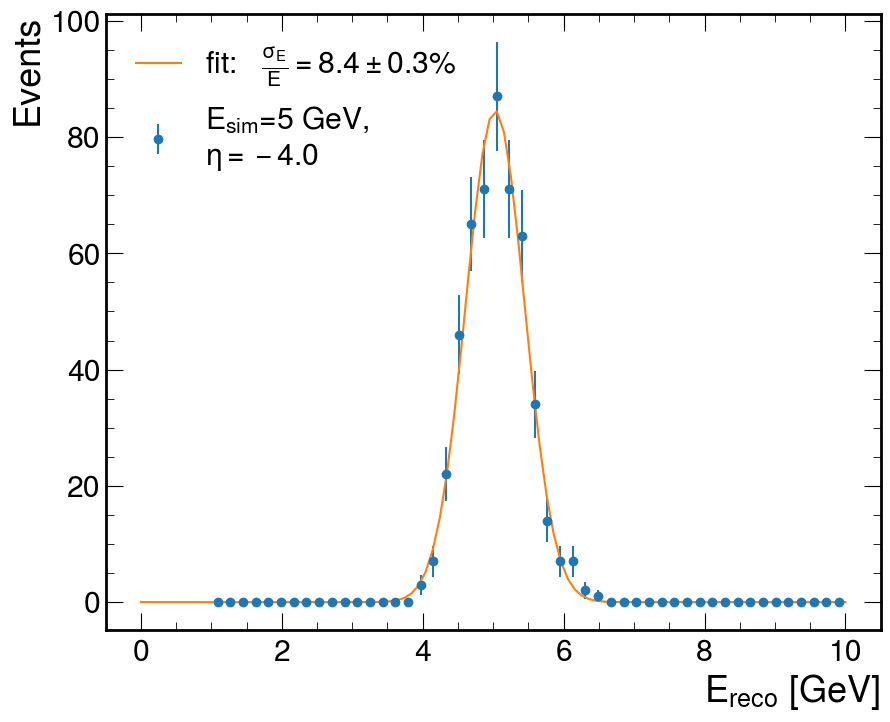

sampling fraction=0.0325
chi2=1.558, ndof=6, pval=0.956


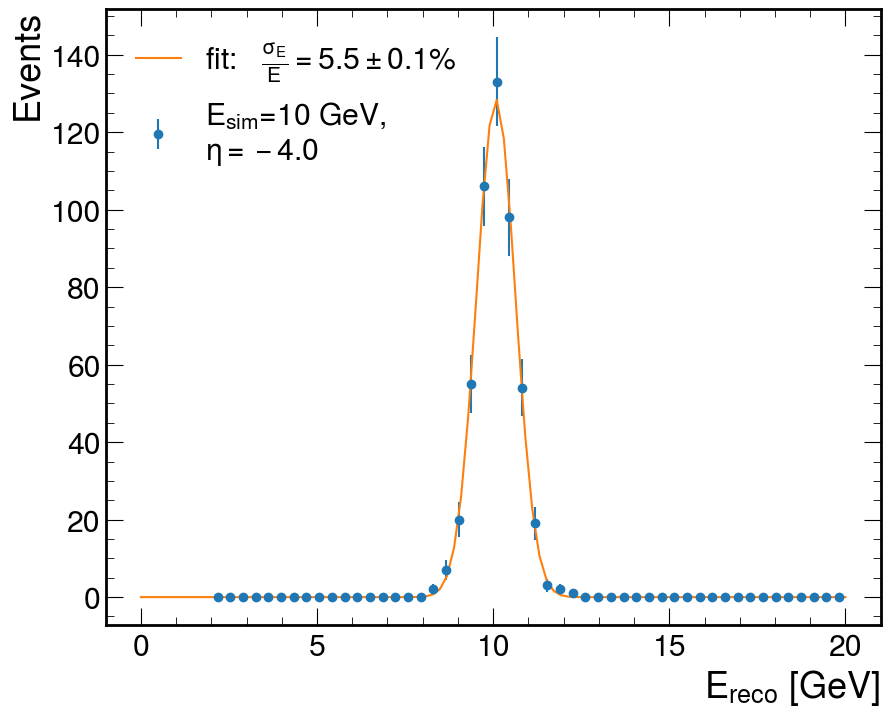

chi2=4.423, ndof=3, pval=0.219


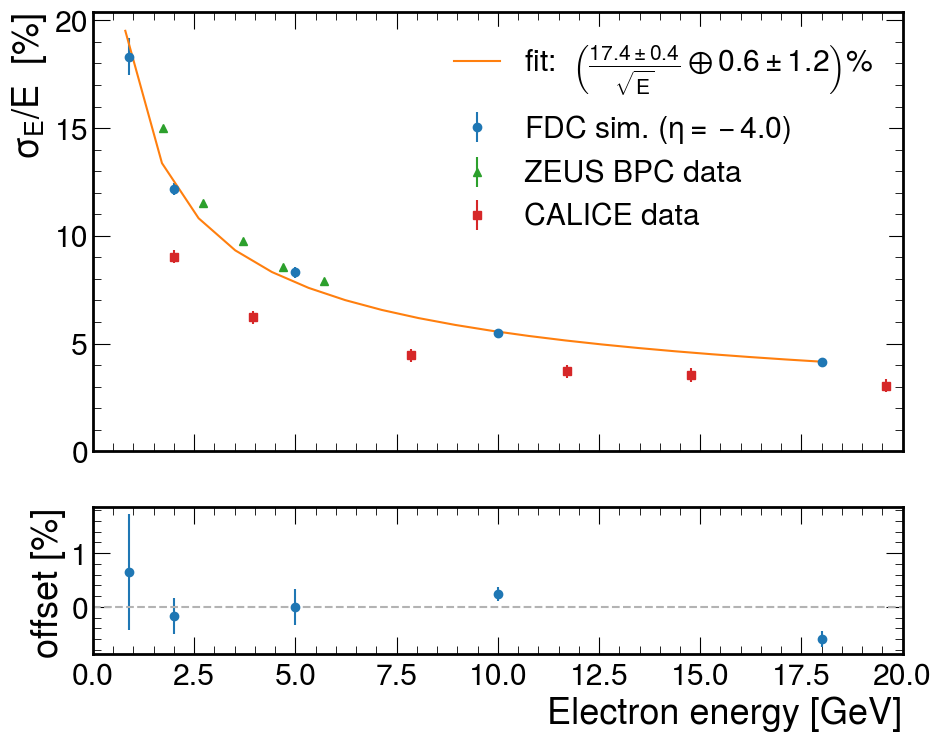

sampling fraction=0.0325
chi2=60.199, ndof=25, pval=9.82e-05


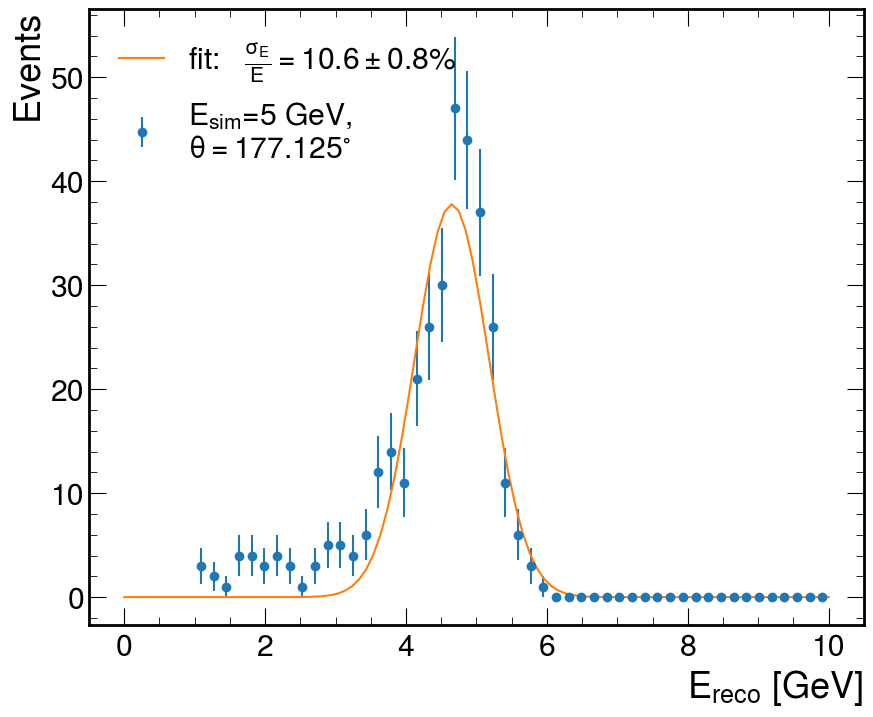

sampling fraction=0.0325
chi2=132.584, ndof=23, pval=2.15e-17


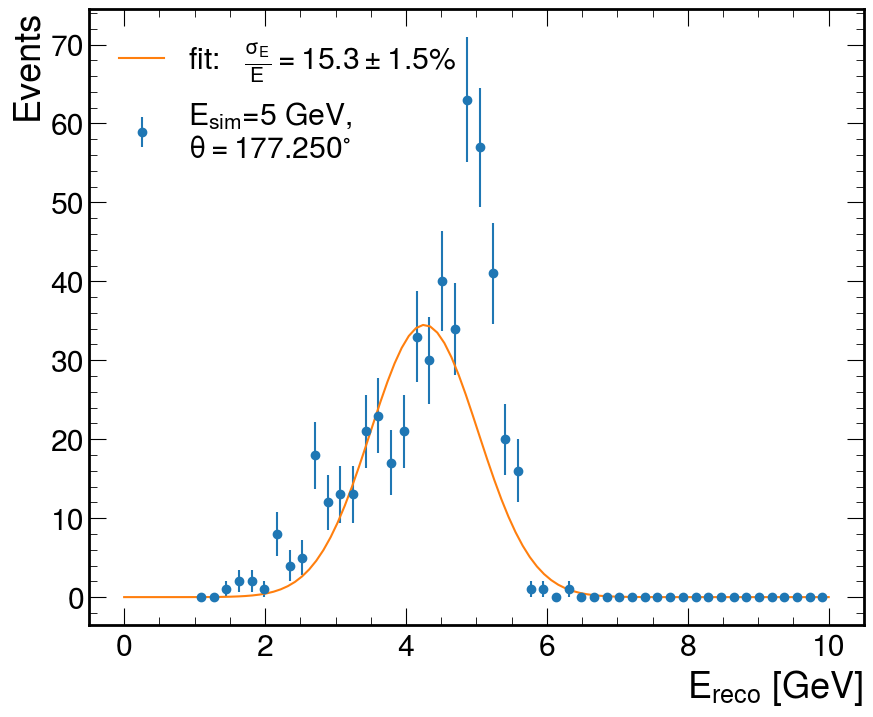

sampling fraction=0.0325
chi2=9.633, ndof=11, pval=0.564


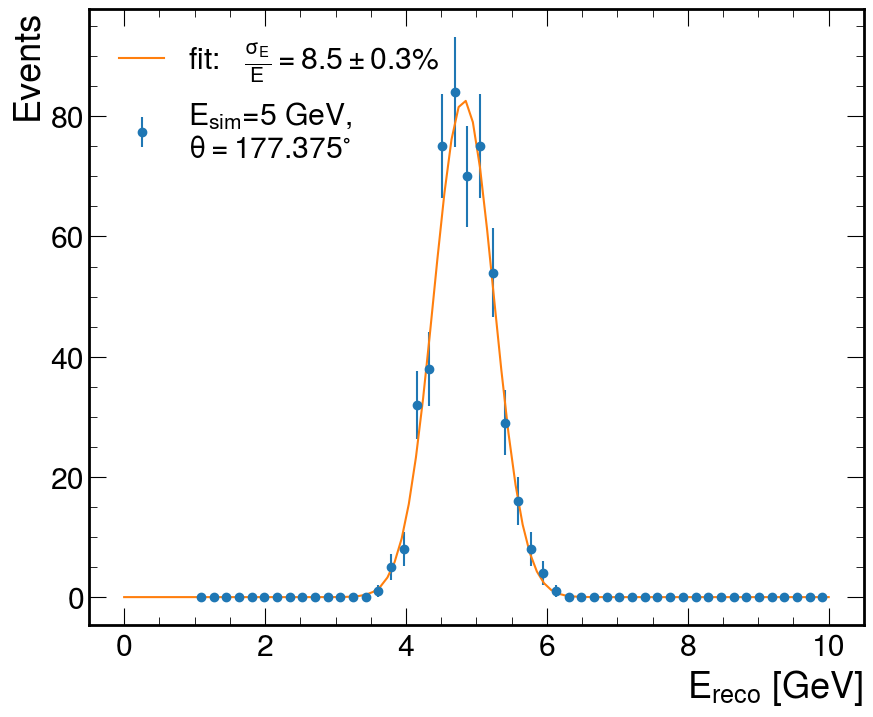

sampling fraction=0.0325
chi2=9.656, ndof=10, pval=0.471


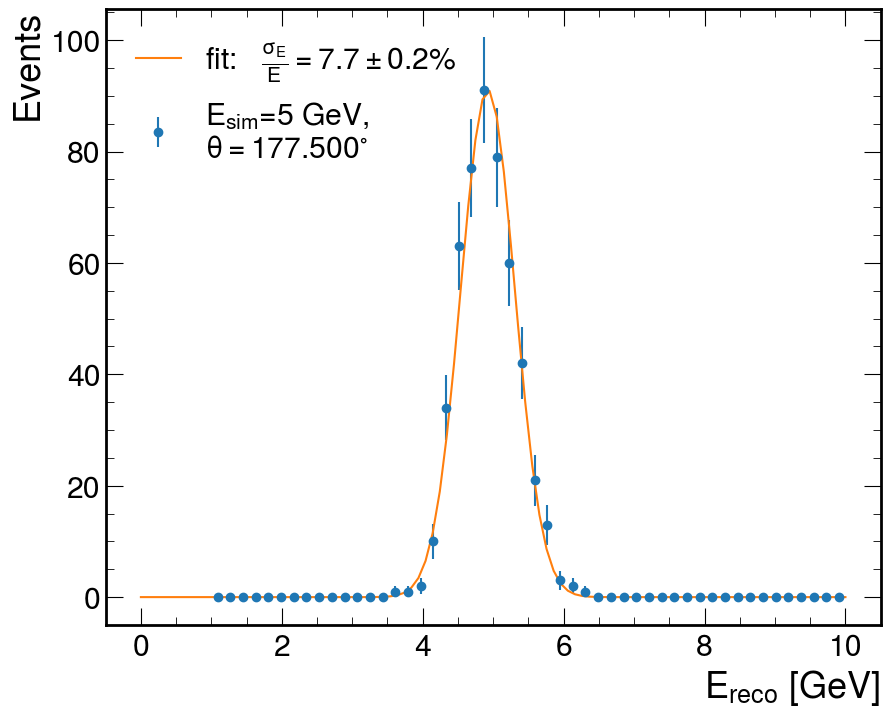

sampling fraction=0.0325
chi2=10.347, ndof=9, pval=0.323


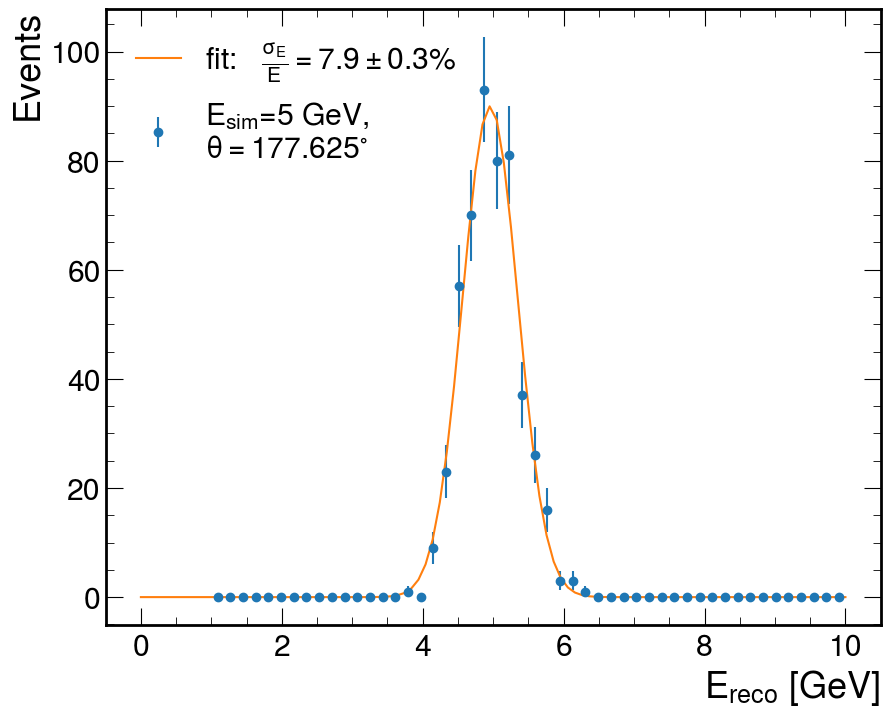

sampling fraction=0.0325
chi2=4.495, ndof=10, pval=0.922


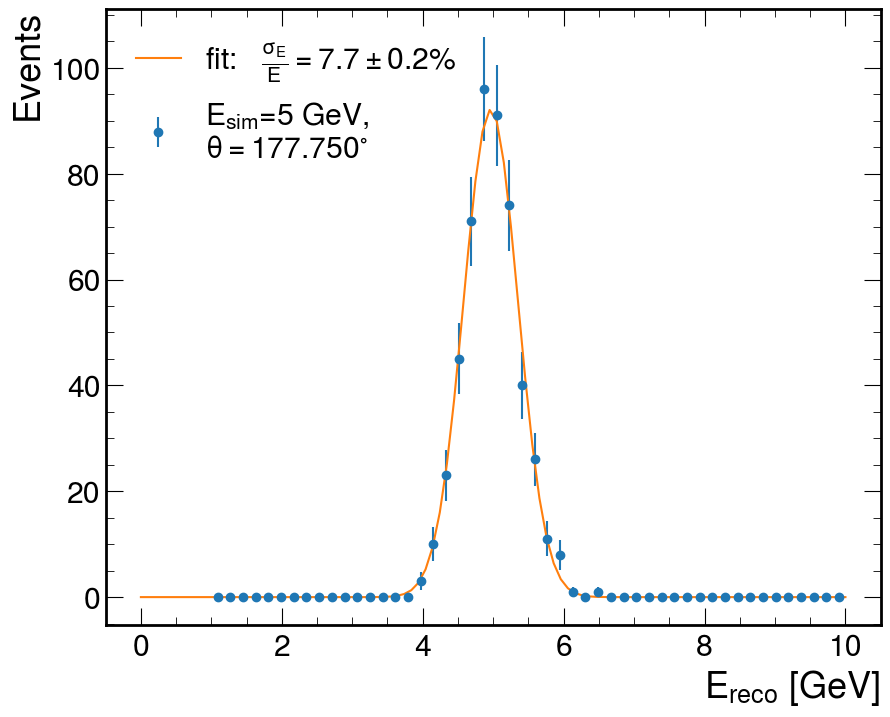

sampling fraction=0.0325
chi2=8.030, ndof=11, pval=0.711


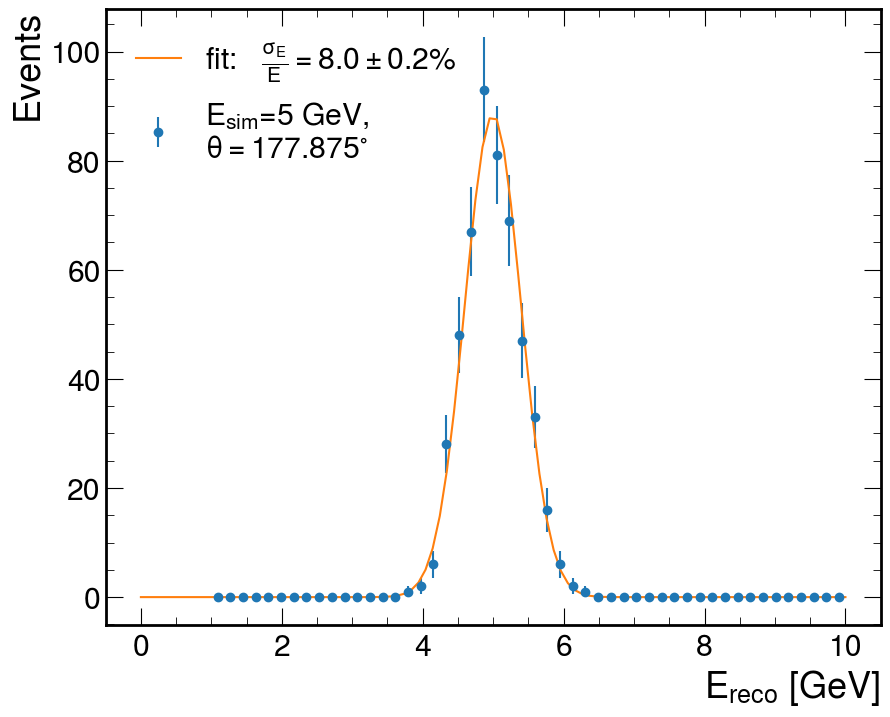

sampling fraction=0.0325
chi2=8.540, ndof=11, pval=0.664


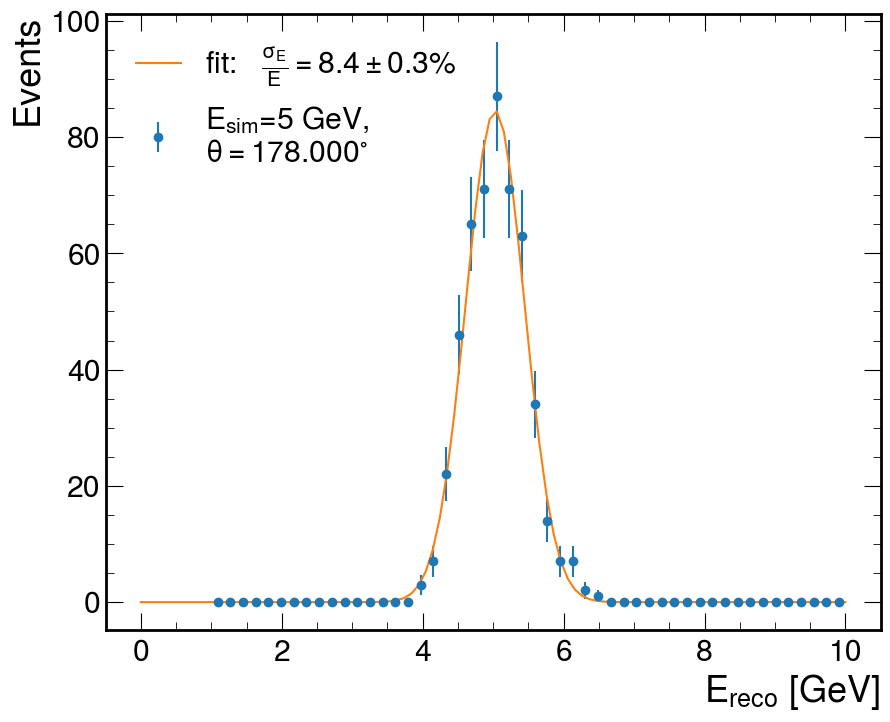

sampling fraction=0.0325
chi2=5.612, ndof=9, pval=0.778


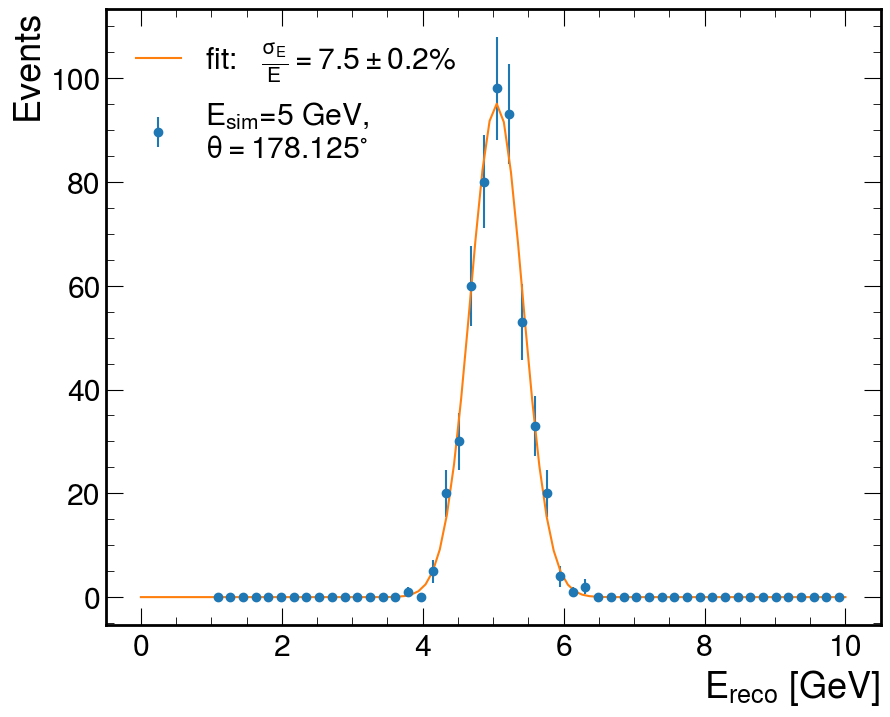

sampling fraction=0.0325
chi2=19.880, ndof=10, pval=0.0304


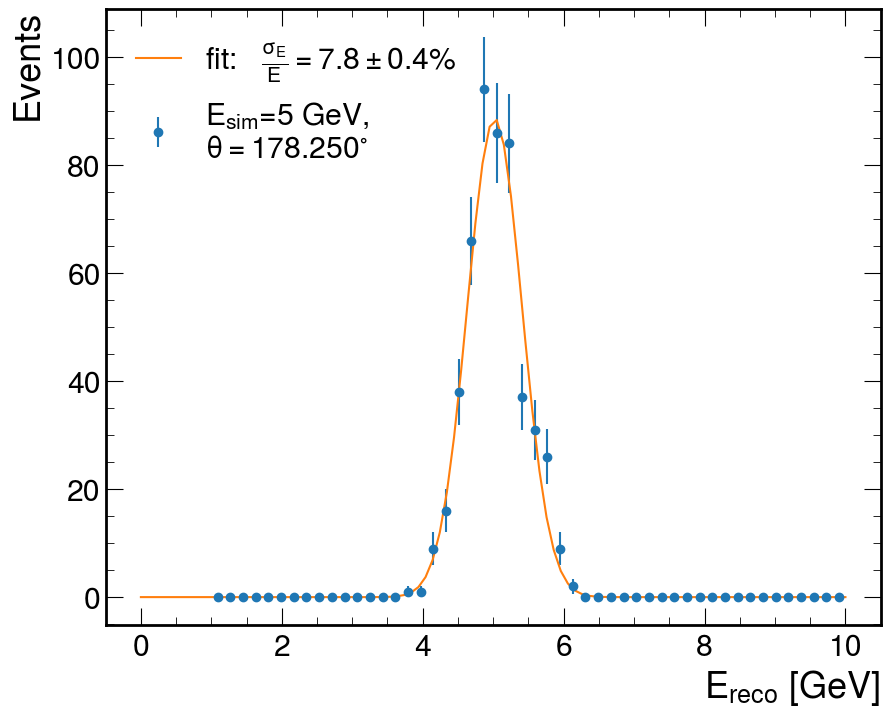

sampling fraction=0.0325
chi2=16.396, ndof=10, pval=0.0889


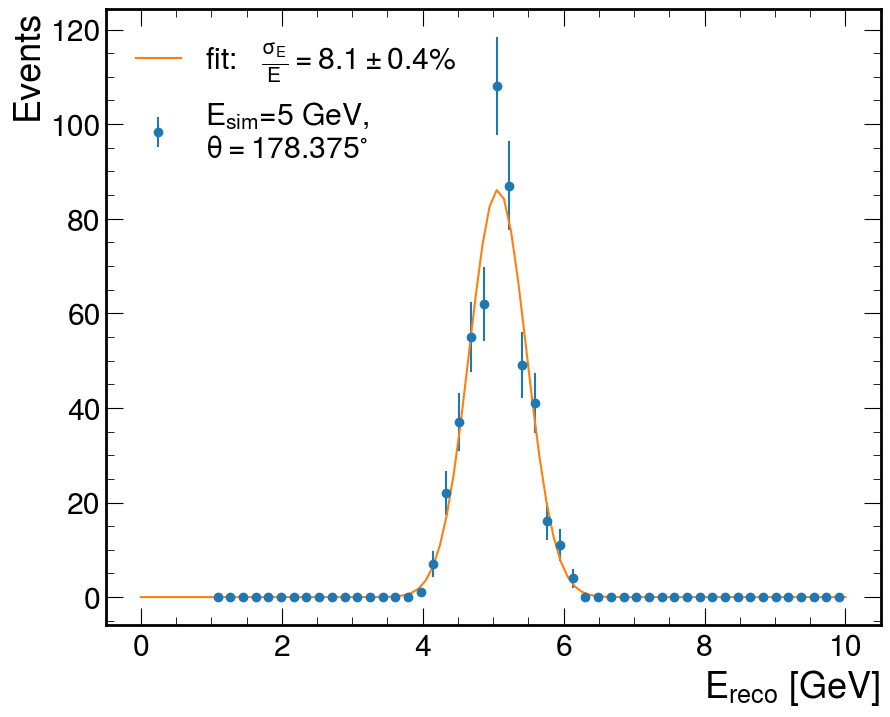

sampling fraction=0.0325
chi2=5.039, ndof=10, pval=0.889


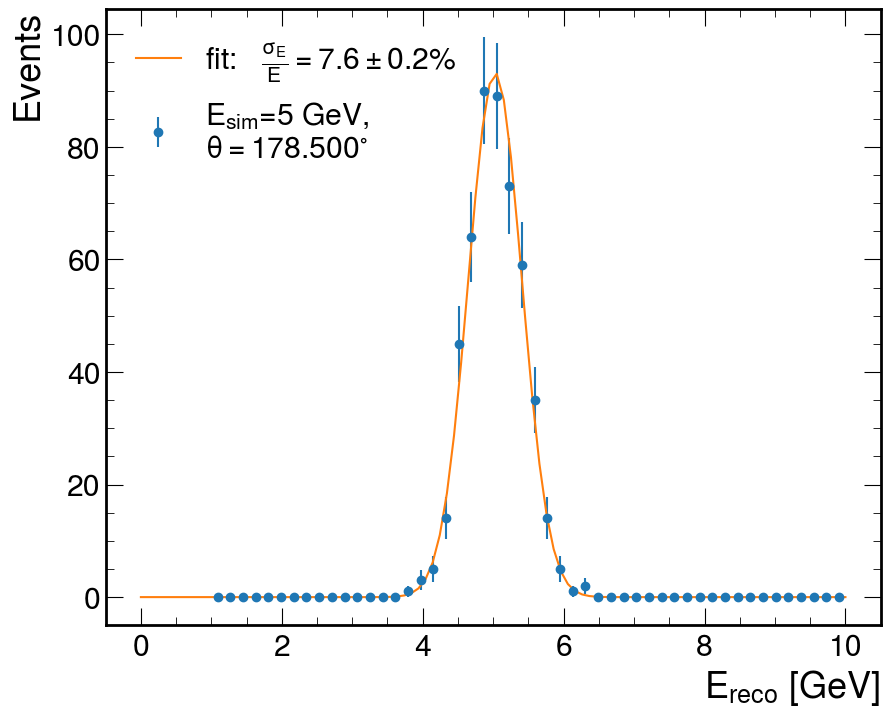

sampling fraction=0.0325
chi2=16.216, ndof=10, pval=0.0936


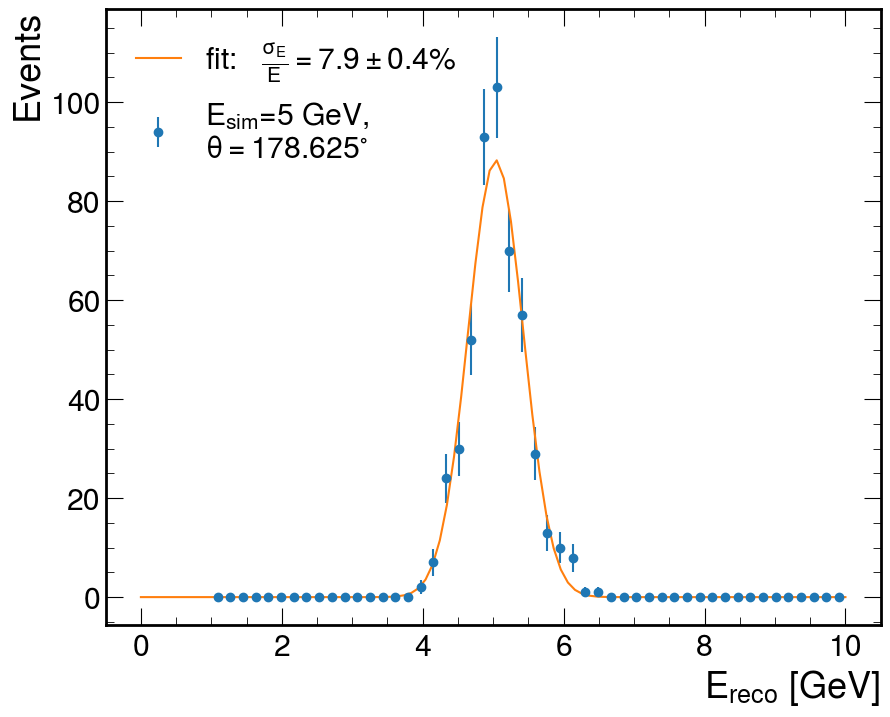

sampling fraction=0.0325
chi2=7.023, ndof=10, pval=0.723


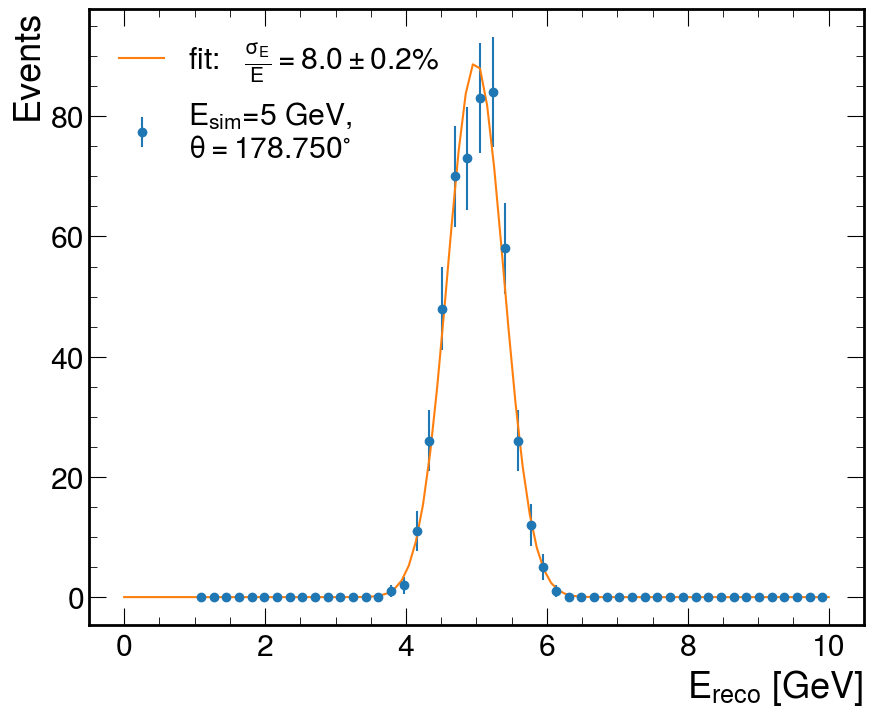

sampling fraction=0.0325
chi2=6.215, ndof=9, pval=0.718


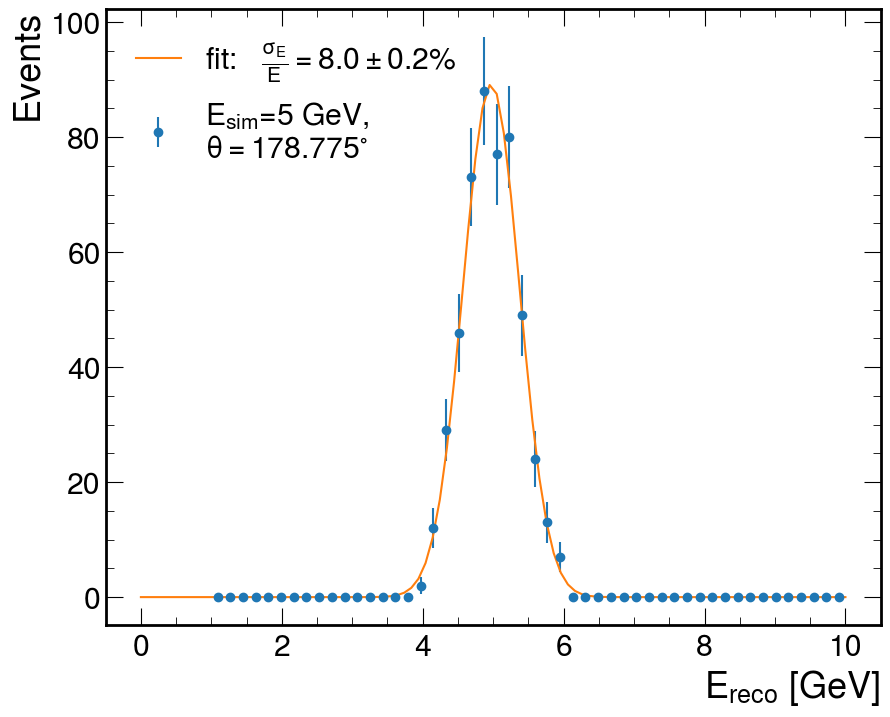

sampling fraction=0.0325
chi2=16.721, ndof=9, pval=0.0533


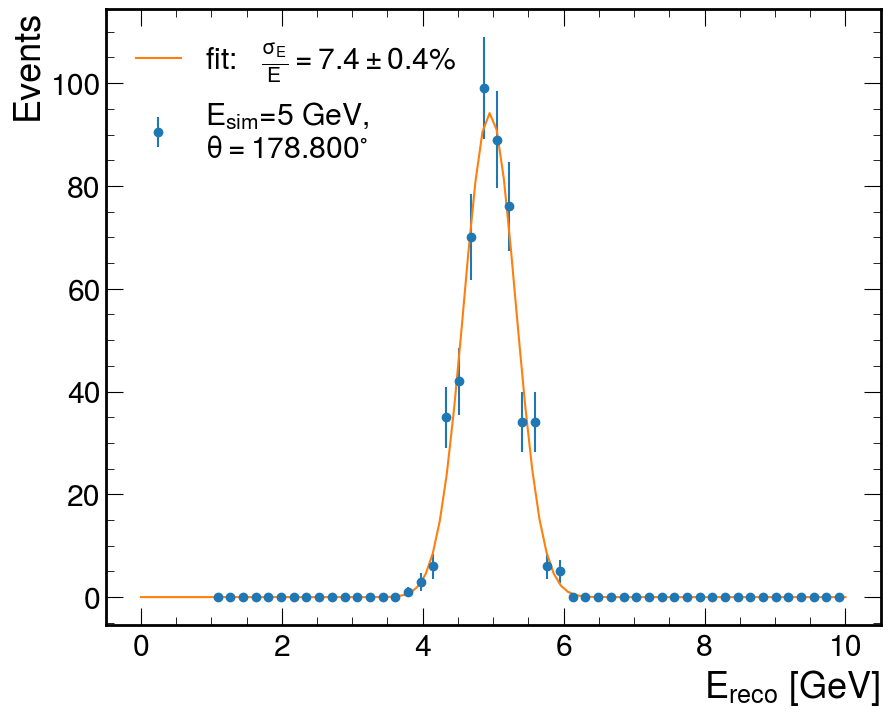

sampling fraction=0.0325
chi2=10.310, ndof=10, pval=0.414


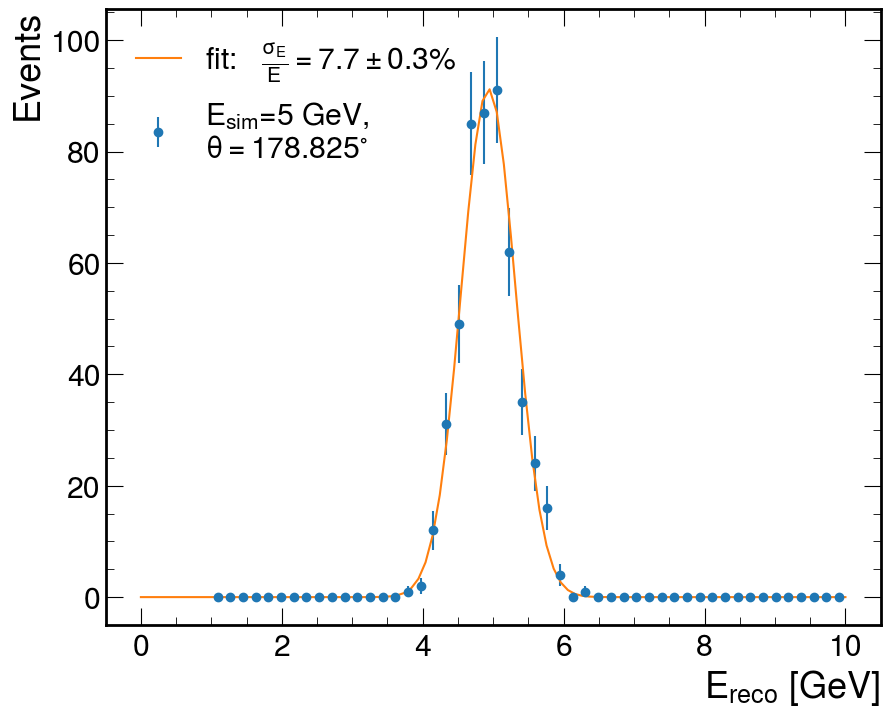

sampling fraction=0.0325
chi2=4.472, ndof=9, pval=0.878


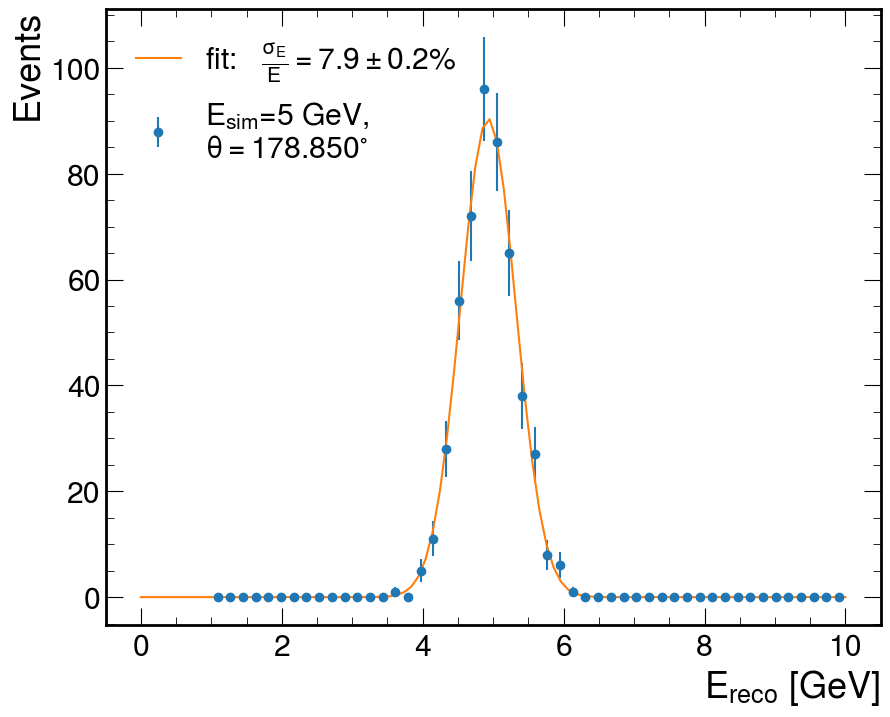

sampling fraction=0.0325
chi2=3.129, ndof=10, pval=0.978


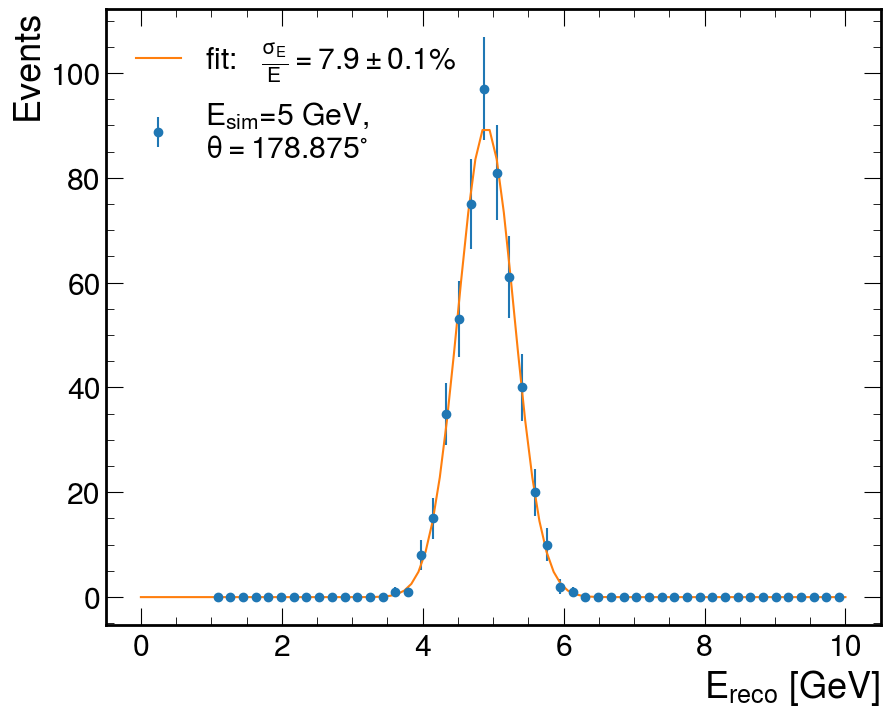

sampling fraction=0.0325
chi2=17.290, ndof=10, pval=0.0682


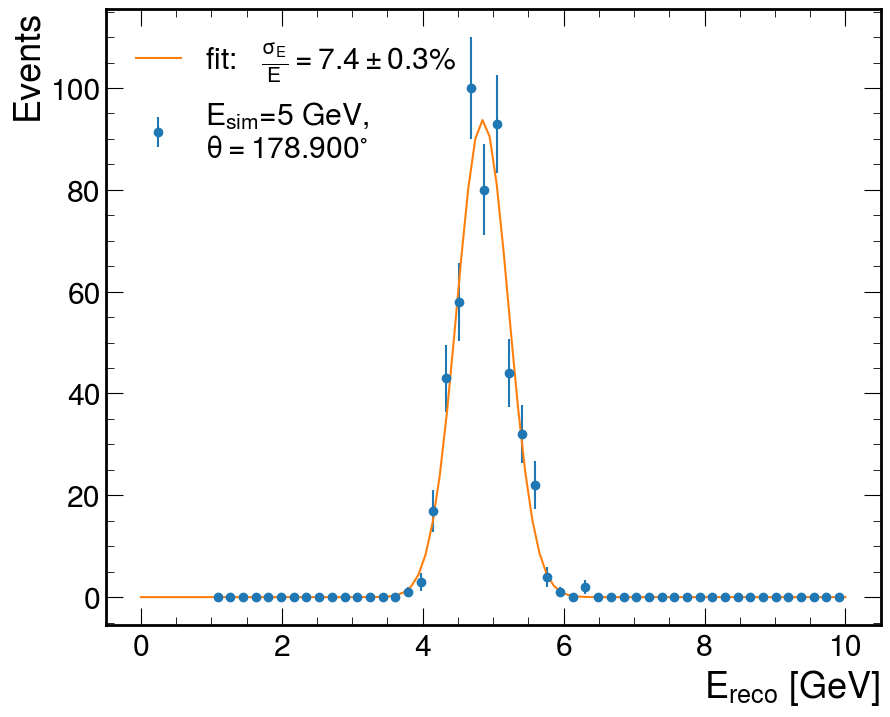

sampling fraction=0.0325
chi2=7.405, ndof=8, pval=0.494


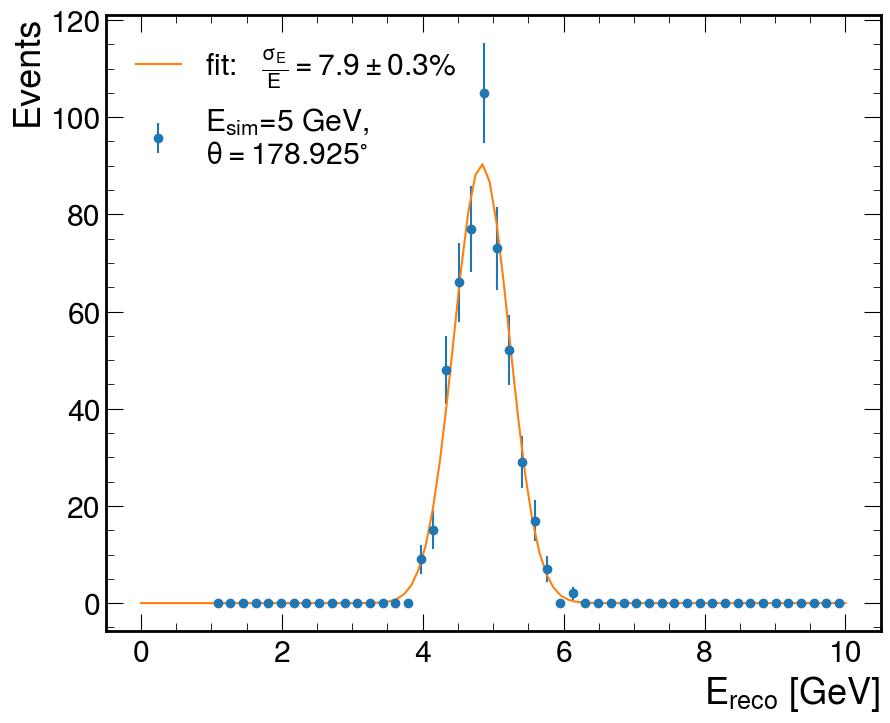

sampling fraction=0.0325
chi2=9.138, ndof=10, pval=0.519


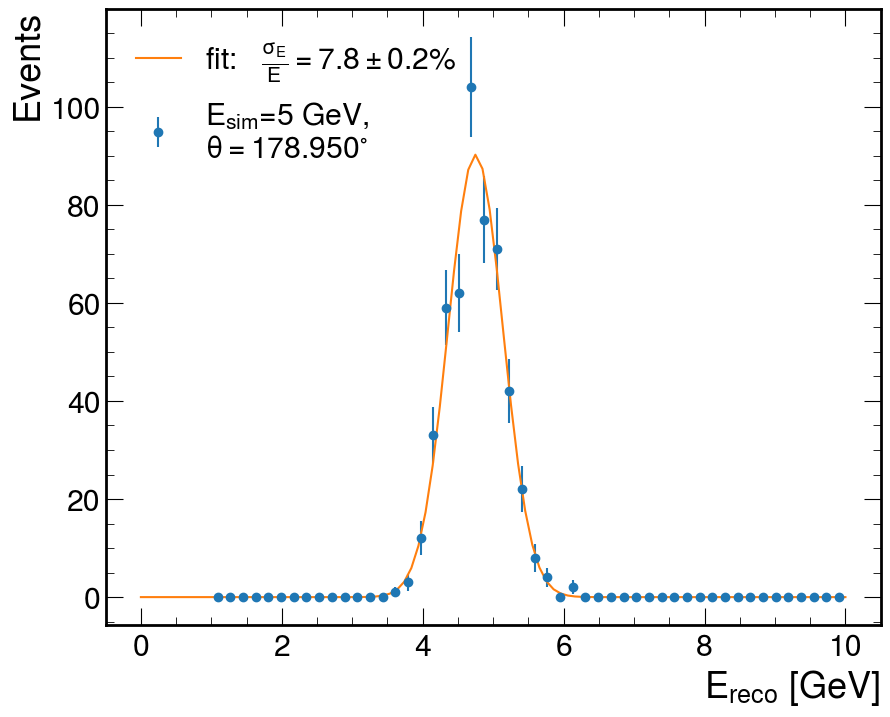

sampling fraction=0.0325
chi2=4.780, ndof=9, pval=0.853


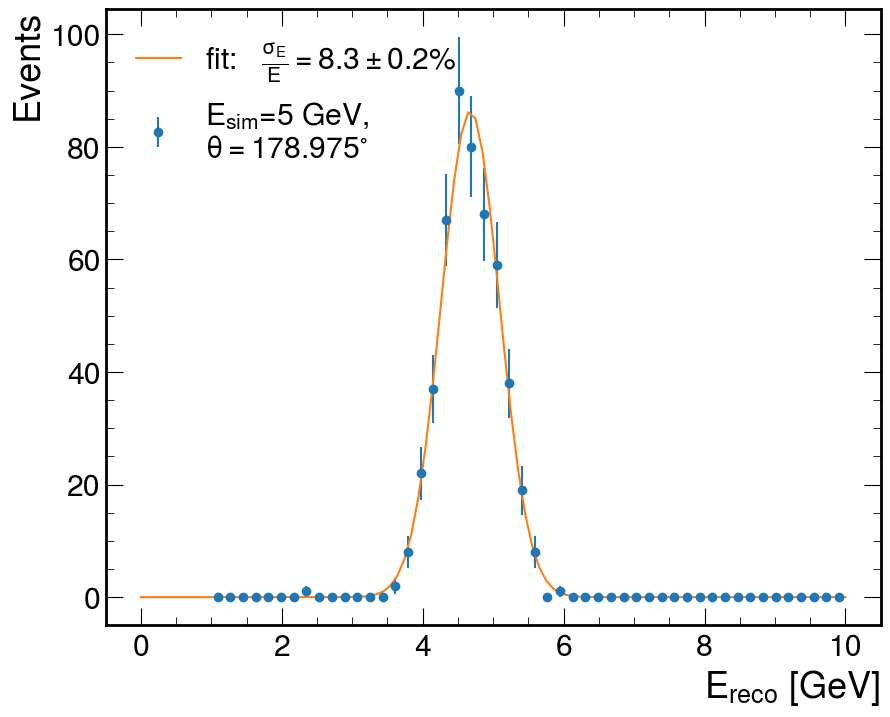

sampling fraction=0.0325
chi2=4.336, ndof=11, pval=0.959


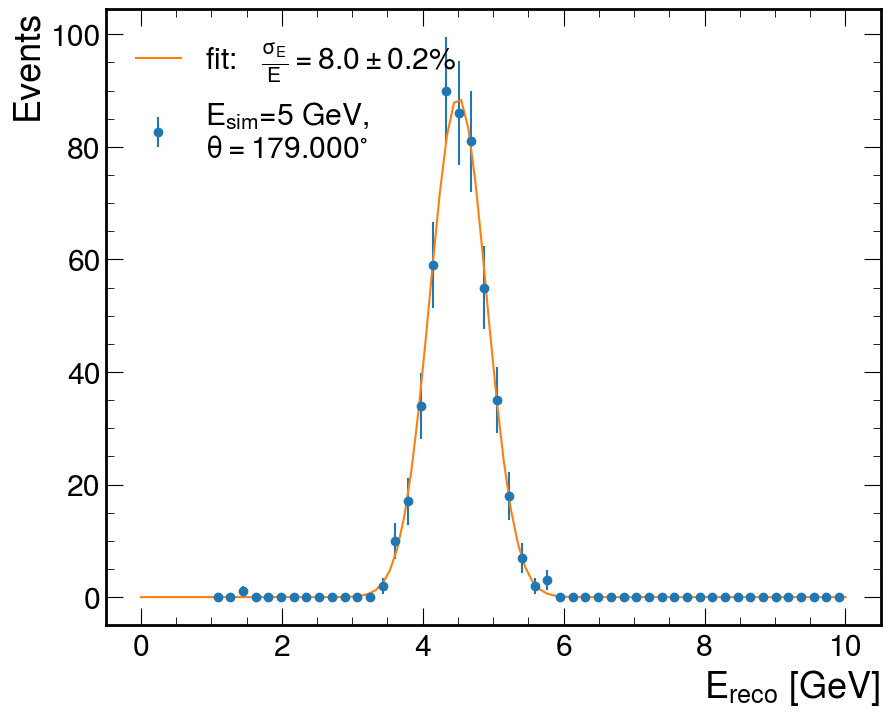

sampling fraction=0.0325
chi2=14.079, ndof=13, pval=0.368


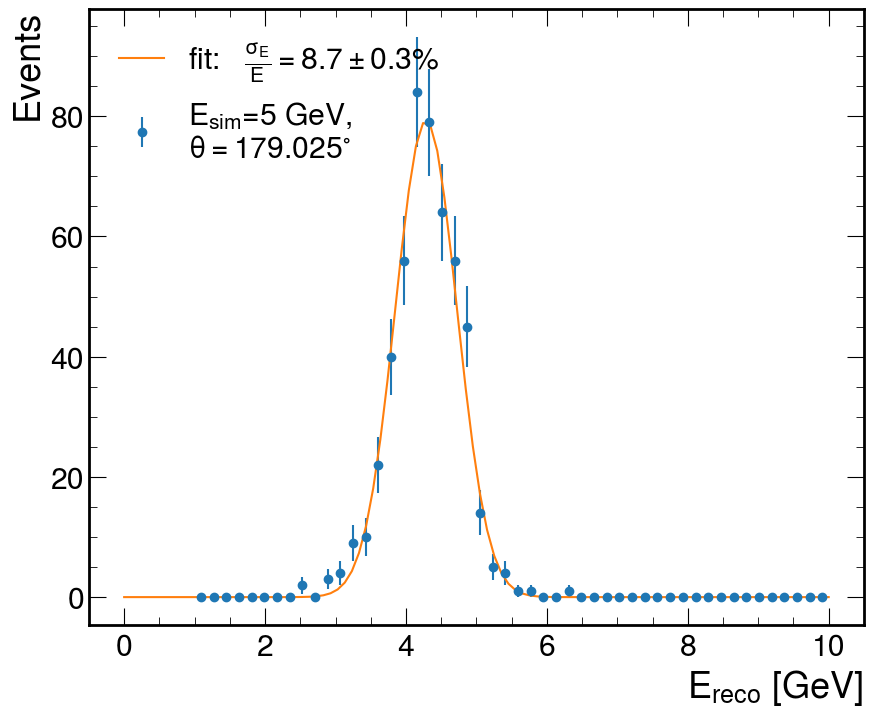

sampling fraction=0.0325
chi2=70.221, ndof=20, pval=1.68e-07


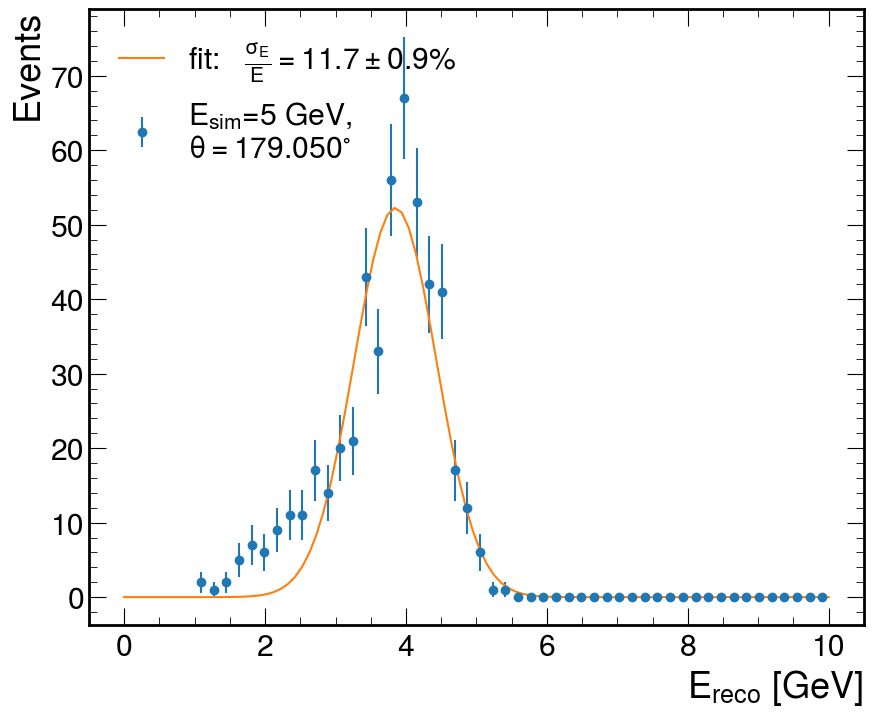

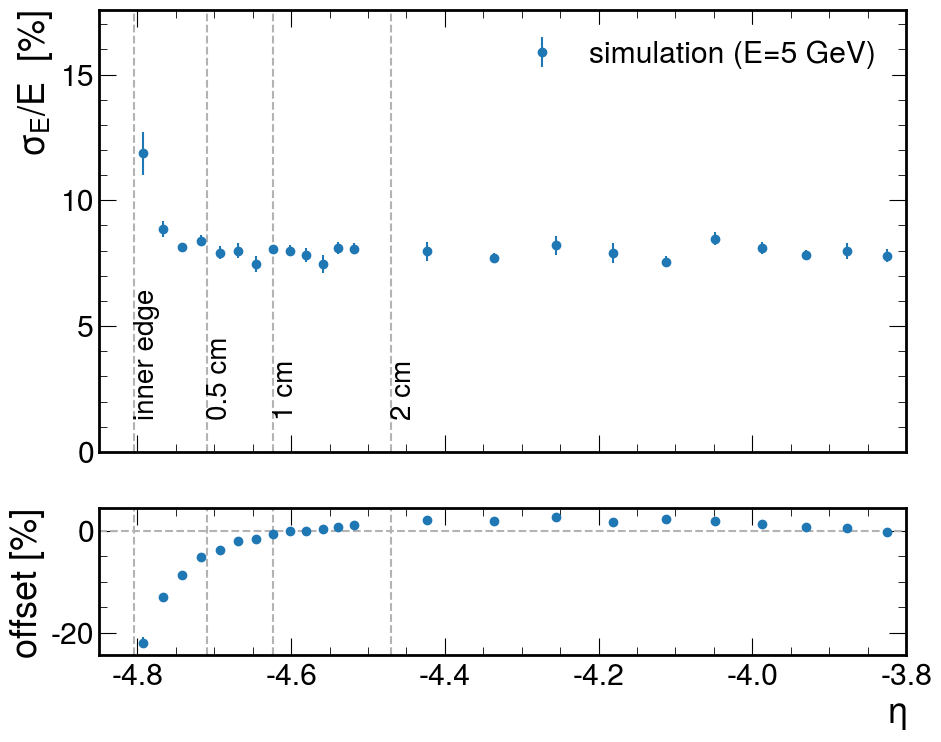

In [16]:
clearance=0.5
R1=4.53
z=-307

sf=None
for var in "E", "theta":
    Eresfracs=[]
    dEresfracs=[]
    
    mus=[]
    dmus=[]
    
    energies=  (18,0.9, 2, 5, 10) if var == "E" else (5,)
    
    #check all values of theta that have been simulated
    all_thetas=[]
    for key in arrays:
        if key[0]==5:
            
            all_thetas.append(key[1])
    all_thetas=np.array(sorted(all_thetas))[:-2]
    
    thetas= all_thetas if var == "theta" else (178,)
    Esums={}

    for theta in thetas:
    
        for E in energies:

            fnc=gauss
            Esums[E]=[]
            for event in range(len(arrays[(E,theta)])):
                Esum=np.sum(arrays[(E,theta)]['BackwardsEcalInsertHitsReco.energy'][event,:])
                #print(Esum)
                MC_E=np.sqrt(sum(arrays[(E,theta)][f"MCParticles.momentum.{a}"][event,2]**2 for a in "xyz"))
                #print(MC_E)
                Esums[E].append(Esum)

            Esums[E]=np.array(Esums[E])
            if sf==None:
                sf=np.mean(Esums[E][Esums[E]>0.1*np.mean(Esums[E])])/E
            print(f"sampling fraction={sf:.4f}")
            Ereco=Esums[E]/sf
            #print(Ereco)
            #print(sf)
            h,x=np.histogram(Ereco, bins=30 if E<5 else 50 if E<18 else 70, range=(0.2*E, 2*E))
            #print(h,x)
            bc=(x[1:]+x[:-1])/2
            p0=[E,np.mean(Ereco), np.std(Ereco)*.8]
            
            
            slc=(h>0) & (abs(bc-np.mean(Ereco))<3*np.std(Ereco))
            
            coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                     sigma=np.sqrt(h[slc]))
            plt.subplots(1,1)
            plt.errorbar(bc, h, np.sqrt(h), marker='o', ls='', 
                         label=f'$E_{{\\rm sim}}$={E} GeV,\n$\\eta=-4.0$' if var=='E'\
                        else f'$E_{{\\rm sim}}$={E} GeV,\n$\\theta={theta:.3f}^{{\\circ}}$')

            Eresfracs.append(coeff[2]/E)
            dEresfracs.append(np.sqrt(var_matrix[2][2])/E)

            mus.append(coeff[1]/E)
            dmus.append(np.sqrt(var_matrix[1][1])/E)
            
            x=np.linspace(0, 2*E, 100)
            plt.plot(x, fnc(x,*coeff), label=f"fit:   $\\frac{{\\sigma_E}}{{E}}={100*Eresfracs[-1]:.1f}\\pm {100*dEresfracs[-1]:.1f}\%$")
            chi2=sum((fnc(bc[slc],*coeff)-h[slc])**2/h[slc])
            ndof = len(bc[slc])-len(coeff)
            from scipy.stats import chi2 as c2
            print(f"chi2={chi2:.3f}, ndof={ndof}, pval={c2.sf(chi2,ndof):.3}")
            plt.xlabel("$E_{\\rm reco}$ [GeV]")
            plt.ylabel("Events")
            plt.legend(loc='upper left')
            if var=='E':
                plt.savefig(f"images/E_res_slice_{E}_GeV.pdf")
            plt.show()
            
    mus=np.array(mus)
    dmus=np.array(dmus)
    
    s=np.median(mus) #fit the mean to be 1.  This is equivalent to doing a calibration of sorts
    
    mus/=s
    dmus/=s
    
    Eresfracs=np.array(Eresfracs)/s
    dEresfracs=np.array(dEresfracs)/s

    fig,axs= plt.subplots(2,1, gridspec_kw=dict(height_ratios=[3,1]),sharex='all')
    plt.sca(axs[0])
    if var == "E":
        plt.errorbar(energies, Eresfracs*100, np.array(dEresfracs)*100, marker='o', ls='',label='FDC sim. ($\\eta=-4.0$)')
        plt.xlim(0, 20)

        axs[1].set_xlabel("Electron energy [GeV]")
        
        from scipy.optimize import curve_fit
        p0=[0.17,0.1]
        fnc=lambda x, a,b: np.hypot(a/np.sqrt(x), b)
        coeff, var_matrix = curve_fit(fnc, energies, Eresfracs, p0=p0,
                                     sigma=dEresfracs)
        coeff_E=coeff
        label=f'fit:  $\\left(\\frac{{{100*coeff[0]:.1f}\\pm {100*np.sqrt(var_matrix[0][0]):.1f}}}{{\\sqrt{{E}}}}'
        label+=f"\\oplus {100*coeff_E[1]:.1f}\\pm {100*np.sqrt(var_matrix[1][1]):.1f}\\right)\%$"

        if not var_matrix[0][0] < 100:
            p0=[0.17]
            fnc=lambda x, a: a/np.sqrt(x)
            coeff, var_matrix = curve_fit(fnc, energies, Eresfracs, p0=p0,
                                     sigma=dEresfracs)
            label=f'fit:  $\\frac{{{100*coeff_E[0]:.1f}\\pm {100*np.sqrt(var_matrix[0][0]):.1f}}}{{\\sqrt{{E}}}}$%'
        
        

        chi2=sum((fnc(energies,*coeff)-Eresfracs)**2/dEresfracs**2)
        ndof = len(energies)-len(coeff_E)
        from scipy.stats import chi2 as c2
        print(f"chi2={chi2:.3f}, ndof={ndof}, pval={c2.sf(chi2,ndof):.3}")

        x=np.linspace(0.8, 18, 20)

        plt.plot(x, 100*fnc(x, *coeff_E), label=label)
        axs[1].errorbar(energies, np.array(mus)*100-100, np.array(dmus)*100, marker='o', ls='')
        plt.errorbar([1.72, 2.71, 3.70, 4.69, 5.70], 100*np.array([0.150, 0.115, 0.0976, 0.0855, 0.0788]), [0]*5,
                label="ZEUS BPC data", ls='', marker='^')
        plt.errorbar(df_CALICE.E, df_CALICE.res, df_CALICE.dres, ls='', marker='s', label="CALICE data")
        
        
        #now cache this for later; the energy resolution as a function of E
        coeff_E=coeff
        
    else:
        plt.errorbar(get_eta(thetas*np.pi/180), Eresfracs*100, np.array(dEresfracs)*100, marker='o', 
                     ls='',label=f'simulation (E={energies[0]} GeV)')
        axs[1].errorbar(get_eta(thetas*np.pi/180), np.array(mus)*100-100, np.array(dmus)*100, marker='o', ls='')
        axs[1].set_xlabel("$\\eta$")
        
        for d in 0, 0.5, 1, 2:
            eta=get_eta(np.pi-np.arctan((d+clearance+R1)/abs(z)))
            plt.axvline(eta, linestyle='--', color='0.7')
            axs[1].axvline(eta, linestyle='--', color='0.7')
            if d:
                plt.text(eta, 1.5, f"{d} cm", rotation=90, fontsize=20)
            else:
                plt.text(eta, 1.5, f"inner edge", rotation=90, fontsize=20)
        plt.xlim(-4.85, -3.8)
    axs[1].set_ylabel("offset [%]")

    #axs[1].set_ylim(-12, 12)
    axs[1].axhline(0, ls='--', color='0.7')
    
    plt.ylabel("${\\sigma_E}/{E}$  [%]")
    plt.legend(loc= 'upper right' if var == 'E' else 'upper right', facecolor='white', framealpha=1, frameon=1, edgecolor='w')
    plt.ylim(0)
    plt.tight_layout()
    plt.savefig(f"images/E_res_vs_{var}.pdf")
    plt.show()

In [ ]:
np.tan(get_theta(-4.80))*-307-4.53-0.5

clearance=0.5
R1=4.53
z=-307
for d in 0, 0.5, 1, 2:
    print(get_eta(np.pi-np.arctan((d+clearance+R1)/abs(z))))


In [1162]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



chi2=1.903, ndof=4, pval=0.754


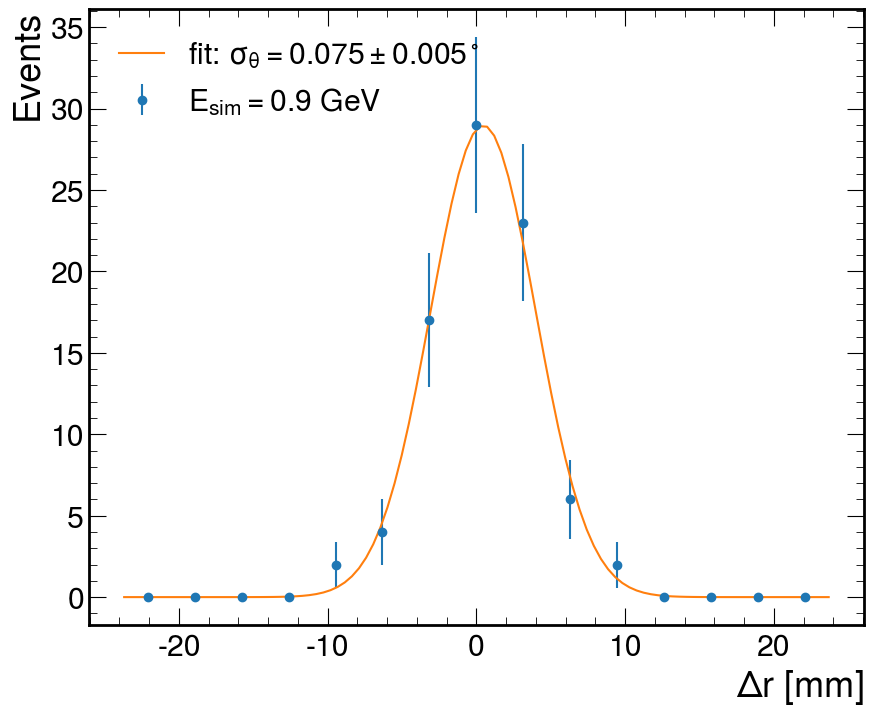

chi2=6.521, ndof=4, pval=0.163


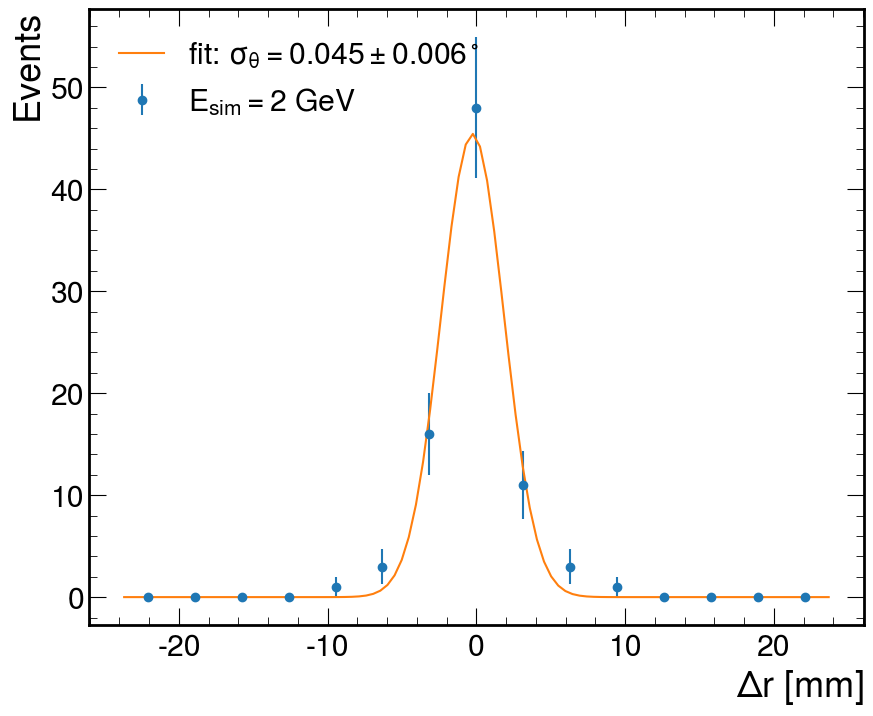

chi2=4.472, ndof=4, pval=0.346


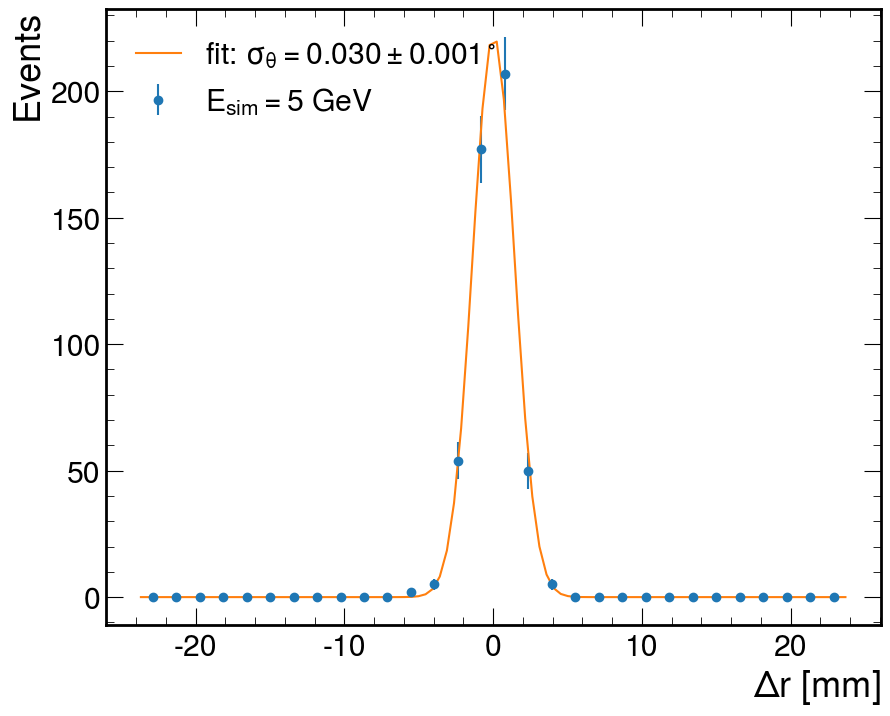

chi2=6.364, ndof=6, pval=0.384


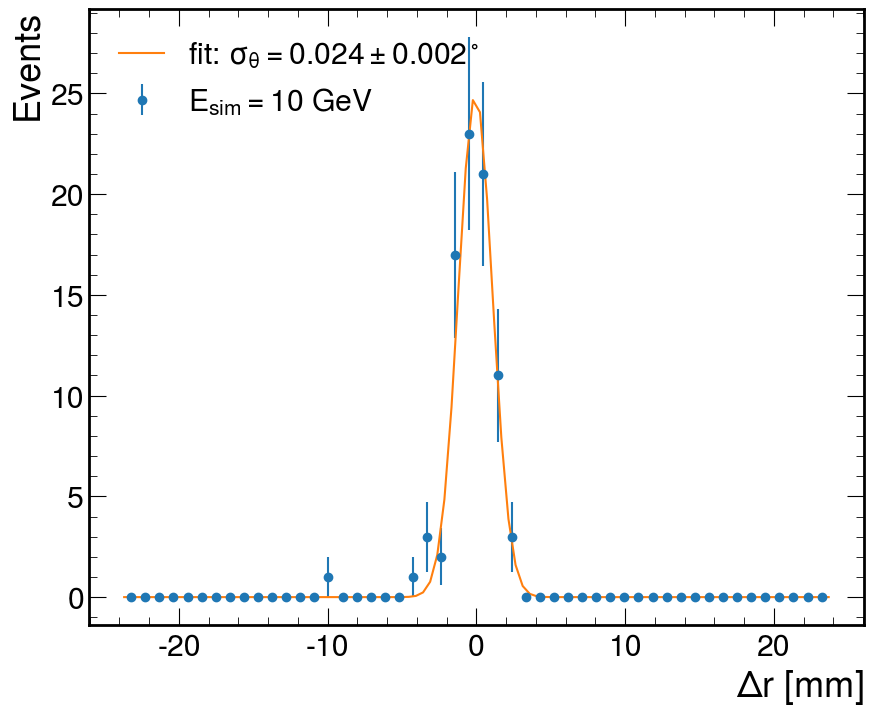

chi2=2.817, ndof=6, pval=0.831


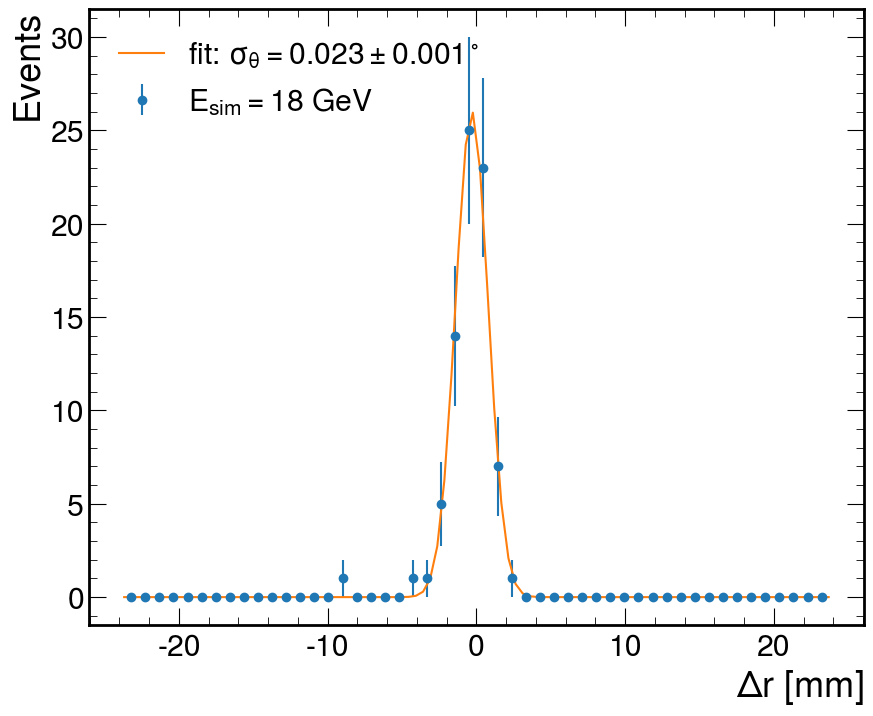

[0.00130136 0.0007811  0.00051779 0.00042428 0.00040321] [8.10446344e-05 9.73128760e-05 1.82417306e-05 3.99917617e-05
 2.43641746e-05]
[3.53222745 2.12012037 1.4054333  1.15160998 1.09442027]
(0.9, 2, 5, 10, 18)
[0.21997688 0.26413326 0.04951295 0.10854837 0.06613091]
chi2=7.9, ndof=3, pval=0.0476


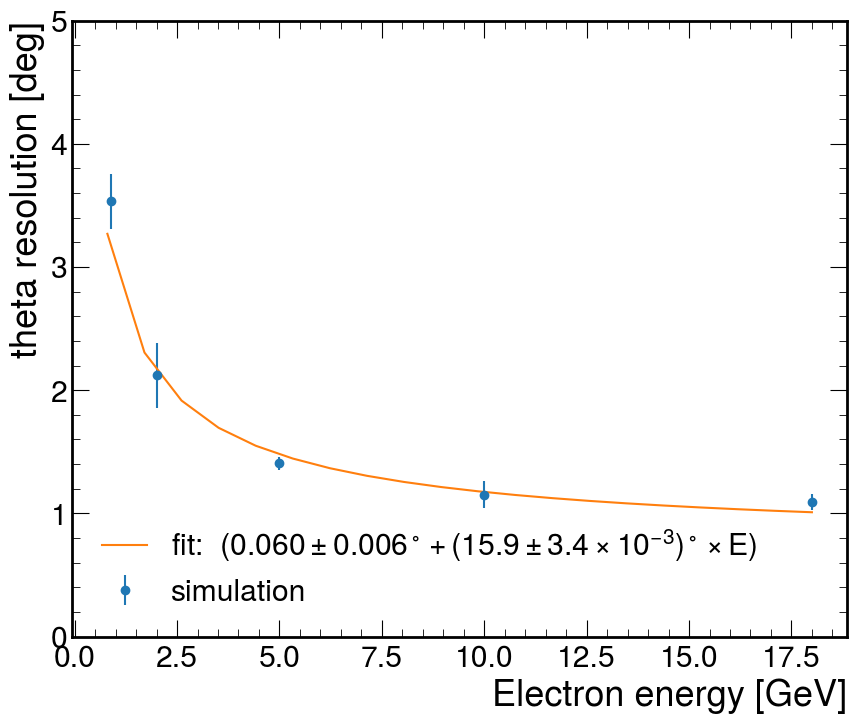

chi2=1.903, ndof=4, pval=0.754


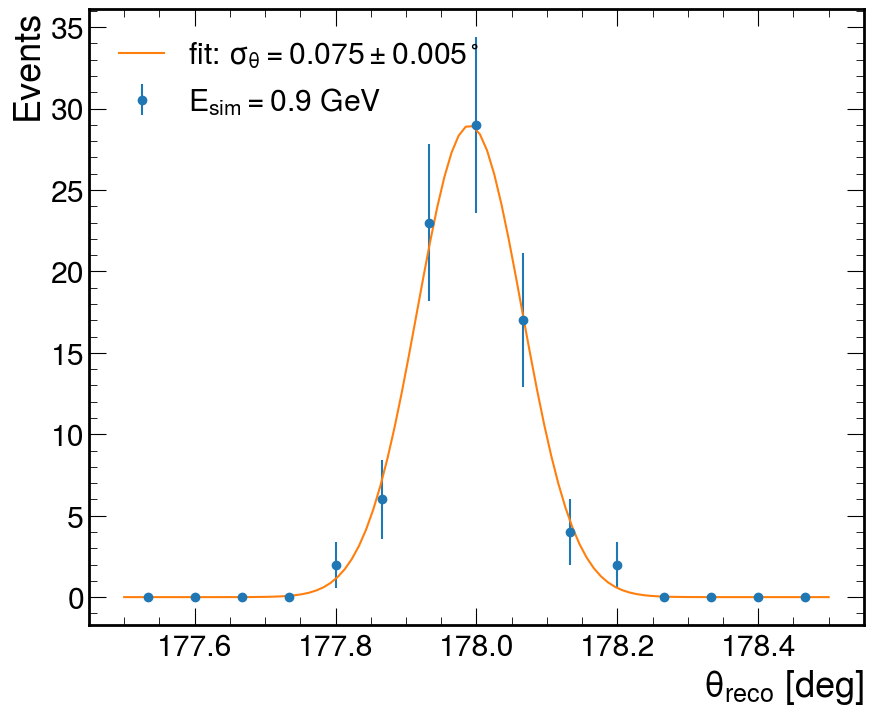

chi2=6.521, ndof=4, pval=0.163


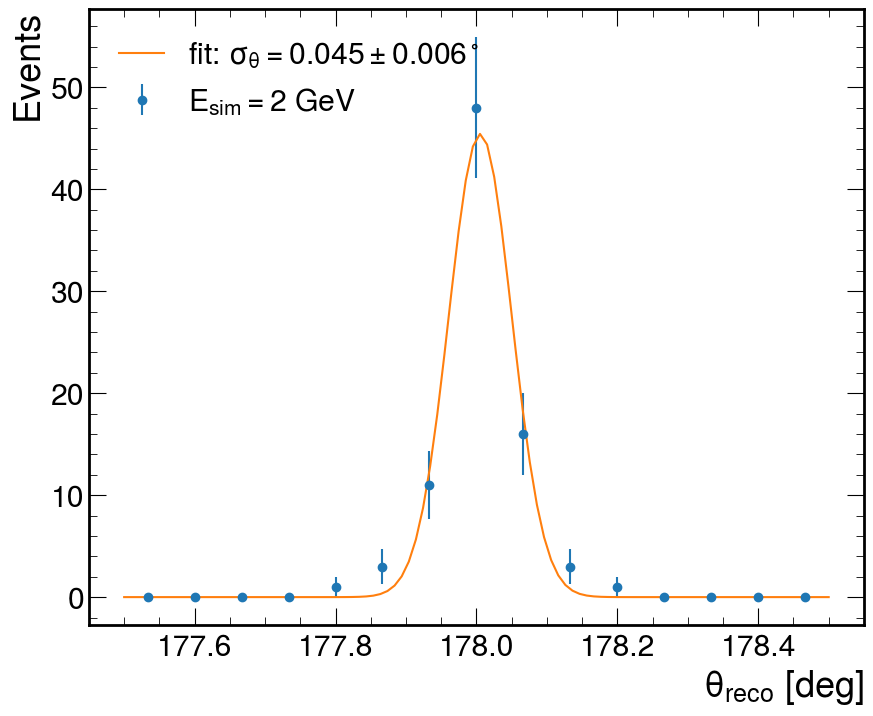

chi2=4.472, ndof=4, pval=0.346


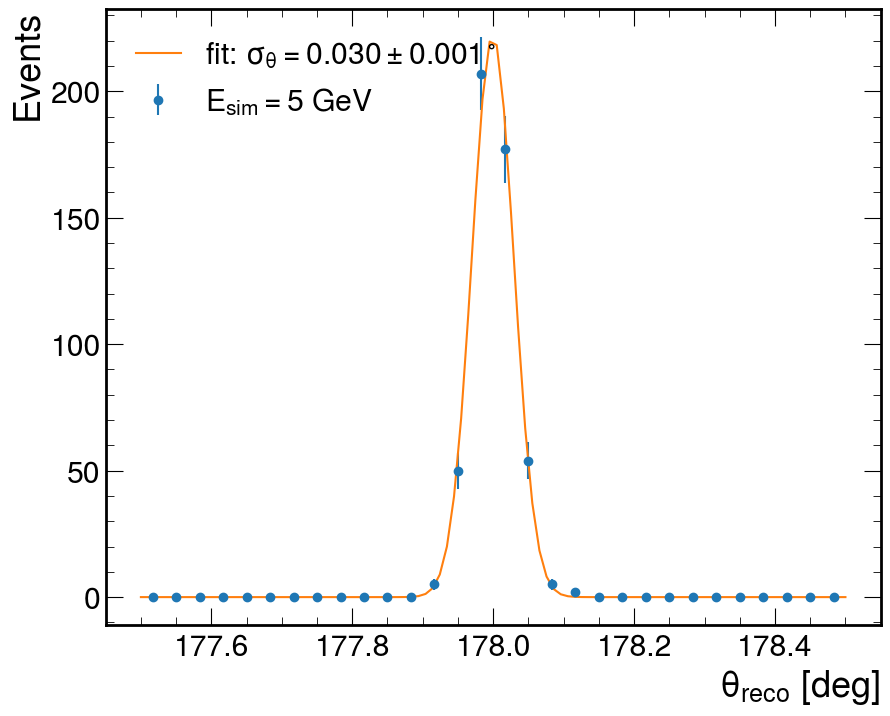

chi2=6.364, ndof=6, pval=0.384


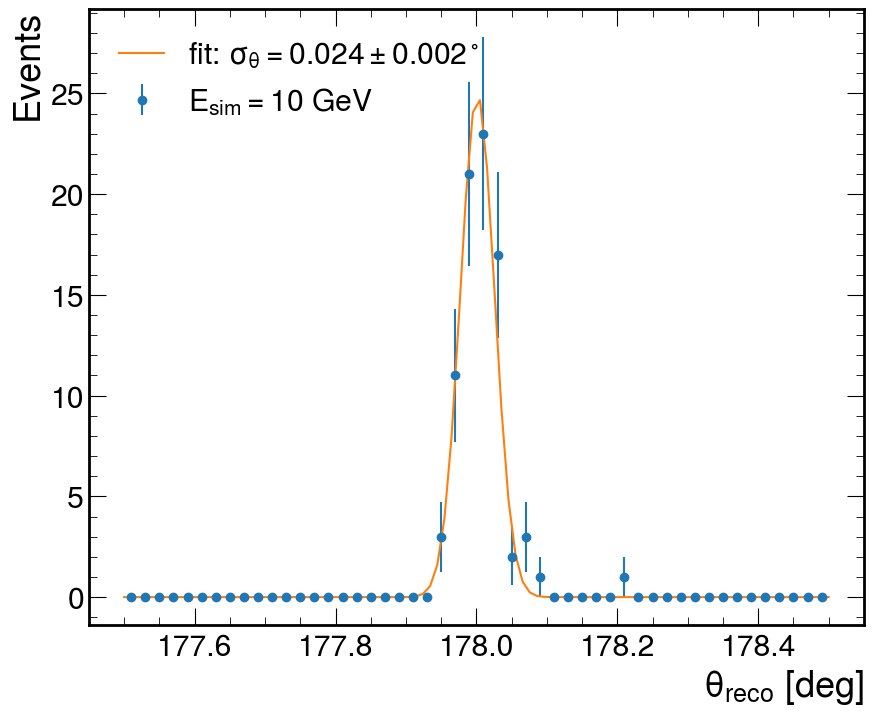

chi2=2.817, ndof=6, pval=0.831


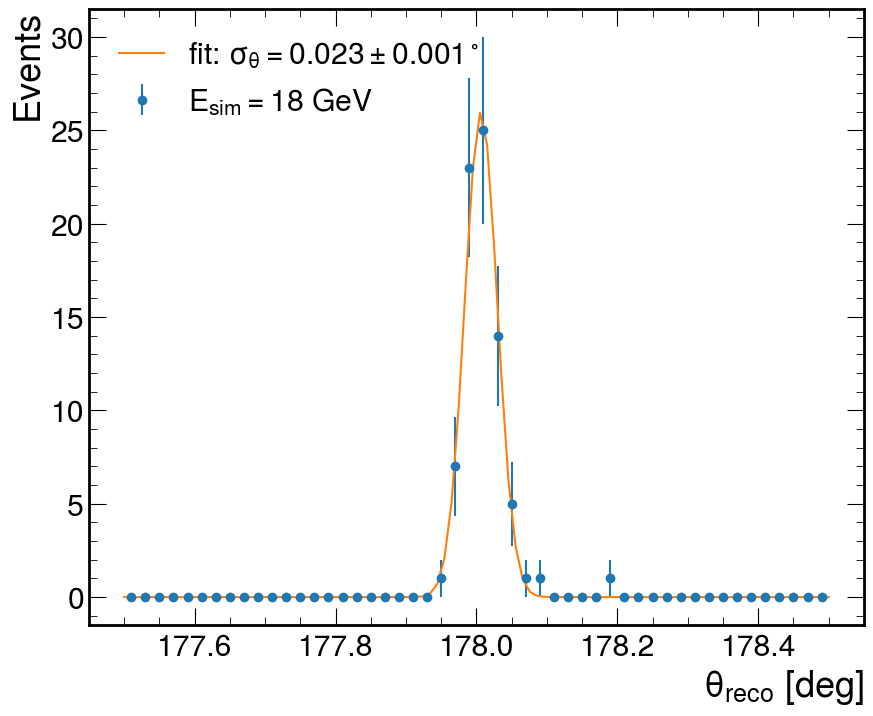

[0.00130136 0.0007811  0.00051779 0.00042428 0.00040321] [8.10446344e-05 9.73128760e-05 1.82417306e-05 3.99917617e-05
 2.43641746e-05]
[0.07456217 0.04475385 0.02966744 0.02430946 0.02310223]
(0.9, 2, 5, 10, 18)
[0.00464352 0.00557562 0.00104517 0.00229136 0.00139596]
chi2=7.9, ndof=3, pval=0.0476


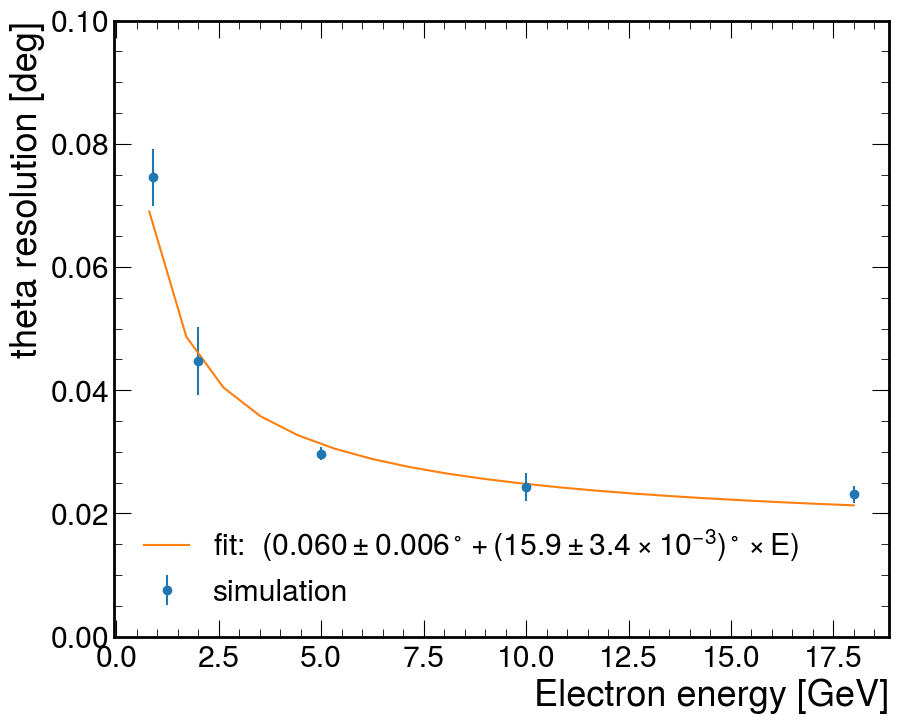

In [1182]:
#get list of z positions of horizontal layers
aa=[]
for a in arrays[(18, 178)]['BackwardsEcalInsertHitsReco.position.z']:
    aa+=list(a)
zh=sorted(set(aa), reverse=True)[::2]

zmax=max(aa)

for unit in "mm", "deg":
    energies= 0.9,2, 5, 10, 18
    thetares=[]
    dthetares=[]

    for E in energies:
        fnc=gauss
        dthetas=[]
        thetas=[]
        key=(E, 178)
        for event in range(len(arrays[key])):

            x=arrays[key]['BackwardsEcalInsertHitsReco.position.x'][event,:]
            y=arrays[key]['BackwardsEcalInsertHitsReco.position.y'][event,:]
            z=arrays[key]['BackwardsEcalInsertHitsReco.position.z'][event,:]
            Erecon=arrays[key]['BackwardsEcalInsertHitsReco.energy'][event,:]
            weights=Erecon

            isHLayer=np.array([z[i] in zh for i in range(len(z))])
            isVLayer=1-isHLayer

            #skip bad events (ie, ones where only V or only H layers are hit)
            if sum(Erecon*isVLayer) == 0 or sum(Erecon*isHLayer) == 0:
                continue

            x0=float(np.sum(x*Erecon*isVLayer)/np.sum(Erecon*isVLayer))
            y0=float(np.sum(y*Erecon*isHLayer)/np.sum(Erecon*isHLayer))
            #print(x0,y0)
            z0v=sum(z*Erecon*isVLayer)/np.sum(Erecon*isVLayer)
            z0h=sum(z*Erecon*isHLayer)/np.sum(Erecon*isHLayer)

            theta=np.pi-np.arctan(np.hypot(x0/z0v,y0/z0h))

            MC_x=arrays[key]["MCParticles.momentum.x"][event,2]
            MC_y=arrays[key]["MCParticles.momentum.y"][event,2]
            MC_z=arrays[key]["MCParticles.momentum.z"][event,2]
            MC_theta=np.arctan2(np.hypot(MC_x,MC_y),MC_z)
            #print(MC_x, MC_y, MC_z,MC_theta)
            dthetas.append(theta-MC_theta)
            thetas.append(theta)
        #print(thetas)    
        r=(np.pi-2.5*np.pi/180,np.pi-1.5*np.pi/180)
        h,x=np.histogram(thetas, bins=15 if E<5 else 30 if E<10 else 50, range=r)
        #print(h,x)
        bc=(x[1:]+x[:-1])/2
        p0=[10,np.pi-2*np.pi/180, np.std(thetas)]

        slc=h>0
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        plt.subplots(1,1)
        s=180/np.pi if unit =='deg' else z0
        plt.errorbar(bc*s-np.mean(bc*s)*(unit =='mm'), h, np.sqrt(h), marker='o', ls='', label=f'$E_{{\\rm sim}}={E}$ GeV')

        thetares.append(coeff[2])
        dthetares.append(np.sqrt(var_matrix[2][2]))


        x=np.linspace(*r, 100)
        plt.plot(x*s-np.mean(bc*s)*(unit =='mm'), fnc(x,*coeff), label=f"fit: $\\sigma_\\theta={180/np.pi*thetares[-1]:.3f}\\pm {180/np.pi*dthetares[-1]:.3f}^\\circ$")
        chi2=sum((fnc(bc[slc],*coeff)-h[slc])**2/h[slc])
        ndof = len(bc[slc])-len(coeff)
        from scipy.stats import chi2 as c2
        print(f"chi2={chi2:.3f}, ndof={ndof}, pval={c2.sf(chi2,ndof):.3}")
        if unit == "deg":
            plt.xlabel("$\\theta_{\\rm reco}$ [deg]")
        else :
            plt.xlabel("$\Delta r$ [mm]")
        plt.ylabel("Events")
        plt.legend(loc='upper left')
        plt.savefig(f"images/theta_res_{unit}_slice_{E}_GeV.pdf")

        plt.show()
        #thetares.append(np.std(dthetas))
        #dthetares.append(np.std(dthetas)/np.sqrt(2*len(dthetas)))
    thetares=np.array(thetares)
    dthetares=np.array(dthetares)
    print(thetares, dthetares)
    s=180/np.pi if unit =='deg' else abs(z0)
    print(thetares*s)
    print(energies)
    print(dthetares*s)
    plt.errorbar(energies, thetares*s, dthetares*s, ls='', marker='o', label='simulation')
    from scipy.optimize import curve_fit
    p0=[0.0001, 0.0001]
    fnc=lambda x, a,b: np.hypot(a/np.sqrt(x), b)
    coeff_th, var_matrix = curve_fit(fnc, energies, thetares, p0=p0,
                                 sigma=dthetares)
    chi2=sum((fnc(energies,*coeff_th)-thetares)**2/dthetares**2)
    ndof = len(energies)-len(coeff_th)
    from scipy.stats import chi2 as c2
    print(f"chi2={chi2:.1f}, ndof={ndof}, pval={c2.sf(chi2,ndof):.3}")

    s=1000
    label=f"fit:  $({coeff_th[0]*180/np.pi:.3f}\pm {np.sqrt(var_matrix[0][0])*180/np.pi:.3f}^\\circ" \
            + f" + ({s*coeff_th[1]*180/np.pi:.1f}\pm {s*np.sqrt(var_matrix[1][1])*180/np.pi:.1f}\\times 10^{{-3}})^\\circ\\times E)$" 

    x=np.linspace(0.8, 18, 20)
    
    s=180/np.pi if unit =='deg' else abs(z0)
    plt.plot(x, s*fnc(x, *coeff_th), label=label)

    plt.xlabel("Electron energy [GeV]")
    plt.ylabel("theta resolution [deg]")
    plt.legend(loc='lower left')
    plt.ylim(0, 5 if unit == "mm" else 0.1)
    plt.savefig(f"images/theta_res_{unit}.pdf")
    plt.show()

In [1164]:
def Q2resfrac(eta, Eresfrac, thetares):
    theta=get_theta(eta)
    return np.hypot(Eresfrac, thetares*np.tan(theta/2))

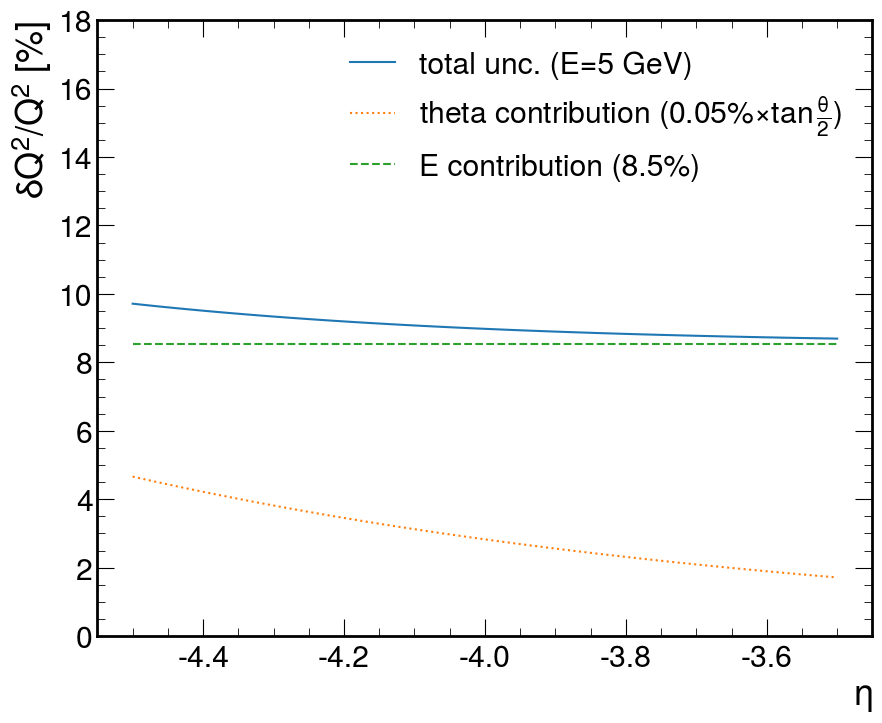

In [1165]:


etas=np.linspace(-4.5, -3.5, 50)

for i in 2,:
    thetaresi=thetares[i]
    Eresfrac=Eresfracs[i]

    plt.plot(etas, 100*Q2resfrac(etas, Eresfrac,thetaresi), label="total unc. (E=5 GeV)")
    plt.plot(etas, 100*Q2resfrac(etas, 0,thetaresi), label=f"theta contribution ({100*thetaresi:.2f}%$\\times\\tan\\frac{{\\theta}}{{2}}$)", ls=':')
    plt.plot(etas, 100*Q2resfrac(etas, Eresfrac,0), label=f"E contribution ({100*Eresfrac:.1f}%)", ls='--')
    plt.xlabel("$\eta$")
    plt.ylabel("$\delta Q^2/Q^2$ [%]")
plt.ylim(0, 18)
plt.legend()
plt.savefig("images/Q2_res_slice_5GeV.pdf")
plt.show()

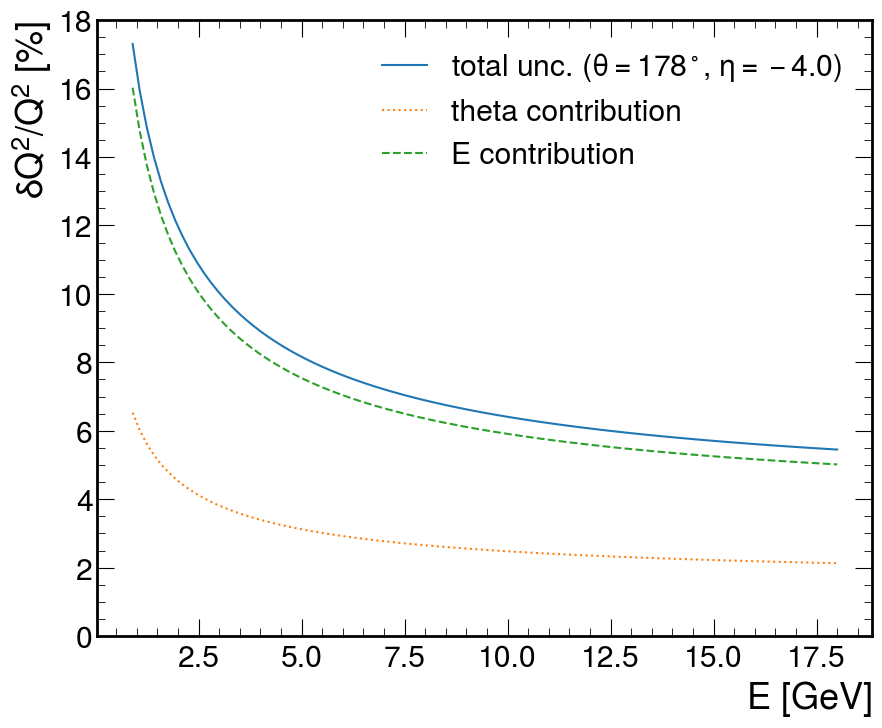

In [1166]:
Es = np.linspace(0.9, 18, 100)

fnc=lambda x, a,b: np.hypot(a/np.sqrt(x), b)


thetaresi=fnc(Es, *coeff_th)
Eresfrac=fnc(Es, *coeff_E)

theta_deg=178
eta=get_eta(theta_deg/180*np.pi)

plt.plot(Es, 100*Q2resfrac(eta, Eresfrac,thetaresi), label=f"total unc. ($\\theta={theta_deg}^\\circ$, $\\eta={eta:.1f}$)")
plt.plot(Es, 100*Q2resfrac(eta, 0,thetaresi), label=f"theta contribution", ls=':')
plt.plot(Es, 100*Q2resfrac(eta, Eresfrac,0), label=f"E contribution", ls='--')
plt.xlabel("$E$ [GeV]")
plt.ylabel("$\delta Q^2/Q^2$ [%]")
plt.ylim(0,18)
plt.legend()
plt.savefig("images/Q2_res_slice_178deg.pdf")
plt.show()

# now compare 0.5 and 0.9 cm versions:

In [757]:
def Eres(arrays, shift=0):
    Eresfracs=[]
    dEresfracs=[]
    energies=  0.9, 2, 5, 10, 18
    Esums={}
    for E in energies:

        fnc=gauss
        Esums[E]=[]
        for event in range(len(arrays[E])):
            Esum=np.sum(arrays[E]['BackwardsEcalInsertHitsReco.energy'][event,:])
            #print(Esum)
            MC_E=np.sqrt(sum(arrays[E][f"MCParticles.momentum.{a}"][event,2]**2 for a in "xyz"))
            #print(MC_E)
            Esums[E].append(Esum)

        Esums[E]=np.array(Esums[E])
        sf=np.mean(Esums[E])/E
        print(f"sampling fraction={sf:.4f}")
        Ereco=Esums[E]/sf
        #print(Ereco)
        #print(sf)
        h,x=np.histogram(Ereco, bins=30 if E<5 else 50 if E<18 else 70, range=(0, 2*E))
        #print(h,x)
        bc=(x[1:]+x[:-1])/2
        p0=[10,np.mean(Ereco), np.std(Ereco)]

        slc=h>0
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))

        Eresfracs.append(coeff[2]/E)
        dEresfracs.append(np.sqrt(var_matrix[2][2])/E)

        chi2=sum((fnc(bc[slc],*coeff)-h[slc])**2/h[slc])
        ndof = len(bc[slc])-len(coeff)
        from scipy.stats import chi2 as c2
        print(f"chi2={chi2:.3f}, ndof={ndof}, pval={c2.sf(chi2,ndof):.3}")

    Eresfracs=np.array(Eresfracs)
    dEresfracs=np.array(dEresfracs)
    return np.array(energies)+shift, Eresfracs*100, dEresfracs*100

In [773]:
def theta_res(arrays,shift=0):
    aa=[]
    for a in arrays[18]['BackwardsEcalInsertHitsReco.position.z']:
        aa+=list(a)
    zh=sorted(set(aa), reverse=True)[::2]

    energies= 0.9,2, 5, 10, 18
    thetares=[]
    dthetares=[]

    for E in energies:
        fnc=gauss
        dthetas=[]
        thetas=[]
        for event in range(len(arrays[E])):
            x=arrays[E]['BackwardsEcalInsertHitsReco.position.x'][event,:]
            y=arrays[E]['BackwardsEcalInsertHitsReco.position.y'][event,:]
            z=arrays[E]['BackwardsEcalInsertHitsReco.position.z'][event,:]
            Erecon=arrays[E]['BackwardsEcalInsertHitsReco.energy'][event,:]
            weights=Erecon

            isHLayer=np.array([z[i] in zh for i in range(len(z))])
            isVLayer=1-isHLayer

            #skip bad events (ie, ones where only V or only H layers are hit)
            if sum(Erecon*isVLayer) == 0 or sum(Erecon*isHLayer) == 0:
                continue

            x0=float(np.sum(x*Erecon*isVLayer)/np.sum(Erecon*isVLayer))
            y0=float(np.sum(y*Erecon*isHLayer)/np.sum(Erecon*isHLayer))
            #print(x0,y0)
            z0v=sum(z*Erecon*isVLayer)/np.sum(Erecon*isVLayer)
            z0h=sum(z*Erecon*isHLayer)/np.sum(Erecon*isHLayer)

            theta=np.pi-np.arctan(np.hypot(x0/z0v,y0/z0h))

            MC_x=arrays[E]["MCParticles.momentum.x"][event,2]
            MC_y=arrays[E]["MCParticles.momentum.y"][event,2]
            MC_z=arrays[E]["MCParticles.momentum.z"][event,2]
            MC_theta=np.arctan2(np.hypot(MC_x,MC_y),MC_z)
            #print(MC_x, MC_y, MC_z,MC_theta)
            dthetas.append(theta-MC_theta)
            thetas.append(theta)
        #print(thetas)    
        r=(np.pi-2.5*np.pi/180,np.pi-1.5*np.pi/180)
        h,x=np.histogram(thetas, bins=15 if E<5 else 30 if E<10 else 50, range=r)
        #print(h,x)
        bc=(x[1:]+x[:-1])/2
        p0=[10,np.pi-2*np.pi/180, np.std(thetas)]

        slc=h>0
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        print(180/np.pi*coeff[1])
        thetares.append(coeff[2])
        dthetares.append(np.sqrt(var_matrix[2][2]))

        #thetares.append(np.std(dthetas))
        #dthetares.append(np.std(dthetas)/np.sqrt(2*len(dthetas)))
    thetares=np.array(thetares)
    dthetares=np.array(dthetares)
    return np.array(energies)+shift,thetares*180/np.pi,dthetares*180/np.pi

{0.0, -126.0, 135.0, 9.0, 144.0, 18.0, -108.0, 27.0, 36.0, -90.0, 45.0, 180.0, 54.0, -72.0, 63.0, -63.0, 72.0, -54.0, 81.0, -45.0, 90.0, -36.0, 99.0, -27.0, 108.0, -18.0, 117.0, -9.0, -135.0}
{0.0, -125.0, -120.0, -115.0, -110.0, -105.0, -100.0, -95.0, -90.0, -85.0, -80.0, -75.0, -70.0, -65.0, -60.0, -55.0, -180.0, -50.0, -175.0, -45.0, -170.0, -165.0, -160.0, -30.0, -140.0, -135.0, -130.0}
sampling fraction=0.0330
chi2=13.130, ndof=11, pval=0.285
sampling fraction=0.0330
chi2=8.380, ndof=6, pval=0.212
sampling fraction=0.0328
chi2=10.868, ndof=9, pval=0.285
sampling fraction=0.0331
chi2=3.277, ndof=5, pval=0.657
sampling fraction=0.0332
chi2=10.266, ndof=5, pval=0.068
sampling fraction=0.0322
chi2=5.945, ndof=9, pval=0.745
sampling fraction=0.0335
chi2=7.862, ndof=5, pval=0.164
sampling fraction=0.0331
chi2=11.818, ndof=6, pval=0.0661
sampling fraction=0.0333
chi2=10.029, ndof=6, pval=0.123
sampling fraction=0.0328
chi2=10.152, ndof=5, pval=0.071
sampling fraction=0.0331
chi2=7.010, n

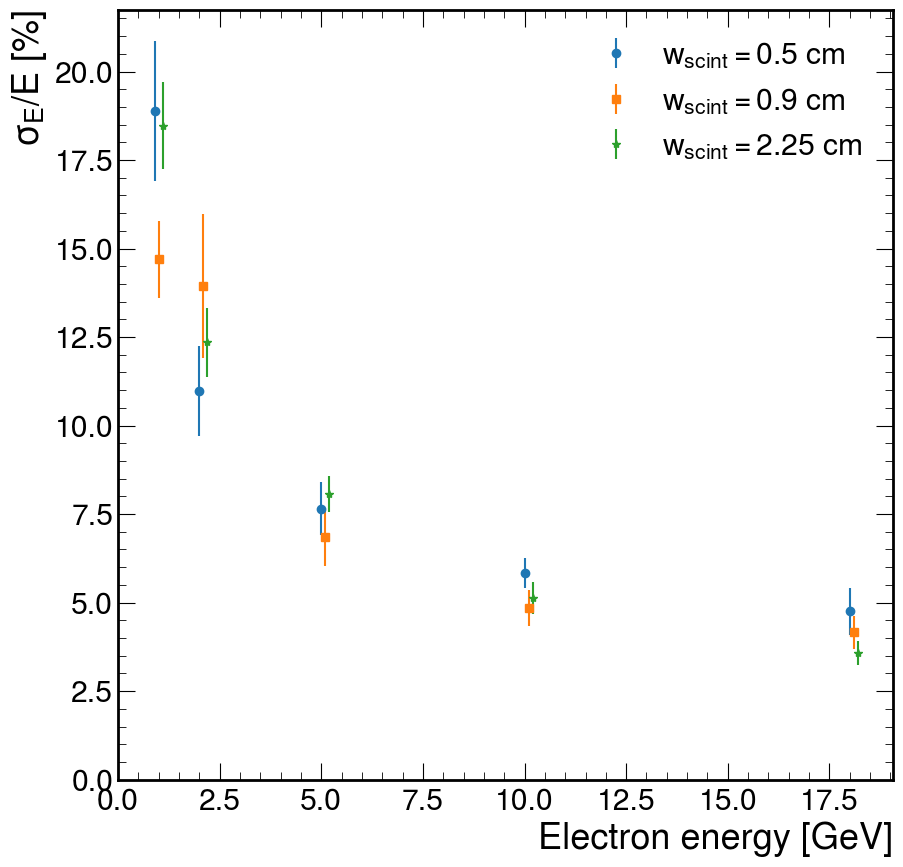

178.0068973481409
177.9976623008841
177.99558305553828
177.99972093837883
178.00134083664642
178.01027946679514
178.00587491687256
178.00920530654753
178.00779605459354
178.00871027885512
177.99430742270258
177.9912306748891
177.9820180710928
178.00352626865885
178.0090132173657


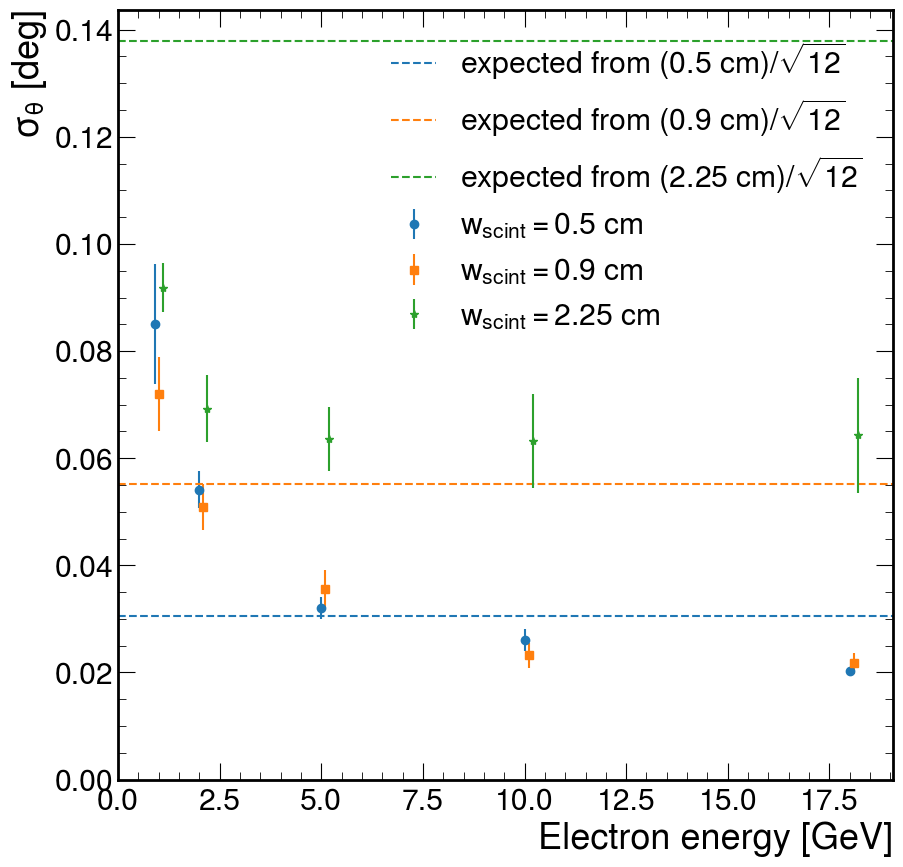

In [783]:
import uproot as ur
arrays_widths={}
for width in 0.9, 0.5, 2.25:
    arrays_widths[width]={}
    for E in 0.9, 2, 5, 10, 18:
        events = ur.open(f'{width}cm/insert_reco_e-_{E}GeV_theta_178-178deg.edm4hep.root:events')
        arrays_widths[width][E] = events.arrays()

print(set(arrays_widths[0.9][18]['BackwardsEcalInsertHitsReco.position.y'][0,:]))
print(set(arrays_widths[0.5][18]['BackwardsEcalInsertHitsReco.position.y'][0,:]))

widths=[0.5, 0.9, 2.25]
markers='os*'
for i in range(len(widths)):
    plt.errorbar(*Eres(arrays_widths[widths[i]], shift=0.1*i), label=f'$w_{{\\rm scint}}={widths[i]}$ cm', ls='', marker=markers[i])
plt.legend()
plt.ylabel("$\\sigma_E/E$ [%]")
plt.xlabel("Electron energy [GeV]")
plt.xlim(0)
plt.ylim(0)
plt.savefig("images/scint_width_vs_E_res.pdf")
plt.show()

for i in range(len(widths)):
    eb=plt.errorbar(*theta_res(arrays_widths[widths[i]], shift=0.1*i), label=f'$w_{{\\rm scint}}={widths[i]}$ cm', ls='', marker=markers[i])
    #calculate the expected resolution from sqrt(12)
    sqrt12res=(180/np.pi)*widths[i]/270/np.sqrt(12)
    plt.axhline(sqrt12res, color=eb[0].get_color(), label=f"expected from ({widths[i]} cm)/$\\sqrt{{12}}$", ls='--')
plt.legend()
plt.ylabel("$\\sigma_\\theta$ [deg]")
plt.xlabel("Electron energy [GeV]")
plt.xlim(0)
plt.ylim(0)
plt.savefig("images/scint_width_vs_theta_res.pdf")
plt.show()

In [911]:
events = ur.open(f'insert_reco_e-_18GeV_theta_180-180deg.edm4hep.root:events')
tmp= events.arrays()


In [912]:
len(tmp['BackwardsEcalInsertHitsReco.position.y'][0])

152

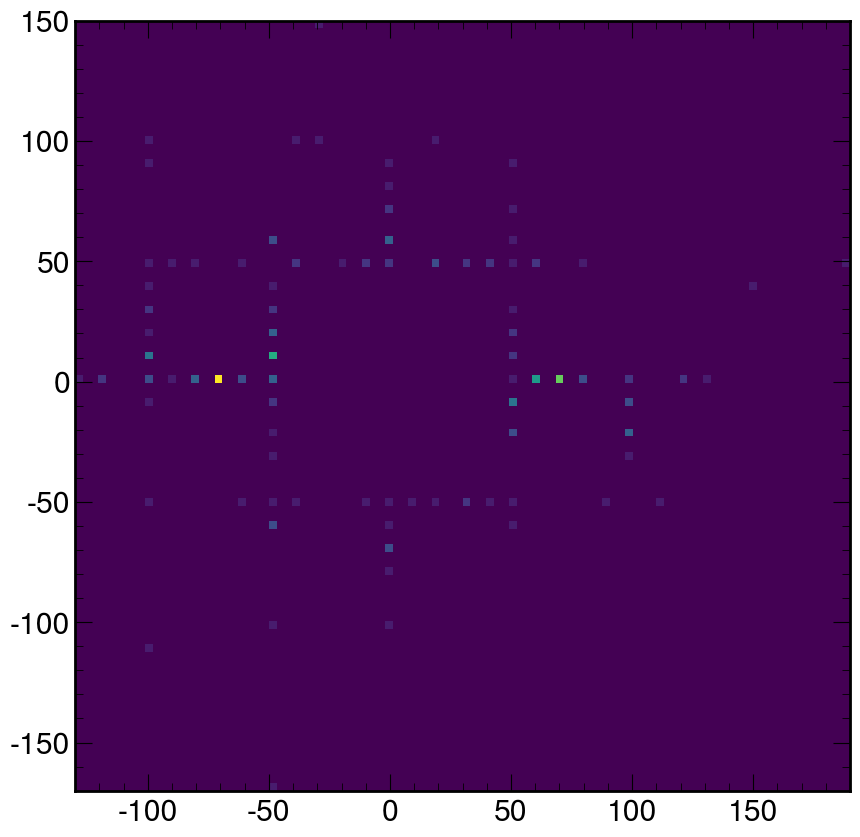

In [943]:
ys=[]
xs=[]
for i in range(500):
    ys+=list(arrays[(5,178.875)]['BackwardsEcalInsertHitsReco.position.y'][i,:])
    xs+=list(arrays[(5,178.875)]['BackwardsEcalInsertHitsReco.position.x'][i,:])
plt.hist2d(xs, ys, bins=100)
plt.show()

In [25]:
arrays[(18, 178)].fields

['BackwardsEcalInsertHitsDigi.cellID',
 'BackwardsEcalInsertHitsDigi.amplitude',
 'BackwardsEcalInsertHitsDigi.timeStamp',
 'BackwardsEcalInsertHitsReco.cellID',
 'BackwardsEcalInsertHitsReco.energy',
 'BackwardsEcalInsertHitsReco.energyError',
 'BackwardsEcalInsertHitsReco.time',
 'BackwardsEcalInsertHitsReco.timeError',
 'BackwardsEcalInsertHitsReco.position.x',
 'BackwardsEcalInsertHitsReco.position.y',
 'BackwardsEcalInsertHitsReco.position.z',
 'BackwardsEcalInsertHitsReco.dimension.x',
 'BackwardsEcalInsertHitsReco.dimension.y',
 'BackwardsEcalInsertHitsReco.dimension.z',
 'BackwardsEcalInsertHitsReco.sector',
 'BackwardsEcalInsertHitsReco.layer',
 'BackwardsEcalInsertHitsReco.local.x',
 'BackwardsEcalInsertHitsReco.local.y',
 'BackwardsEcalInsertHitsReco.local.z',
 'InclusiveKinematicsTruth.x',
 'InclusiveKinematicsTruth.Q2',
 'InclusiveKinematicsTruth.W',
 'InclusiveKinematicsTruth.y',
 'InclusiveKinematicsTruth.nu',
 'InclusiveKinematicsTruth#0.index',
 'InclusiveKinematicsTru

In [32]:
events = ur.open(f'06212023/insert_sim_e-_18GeV_theta_178-178deg.edm4hep.root:events')
a = events.arrays()
print(a.fields)
aa=0
for b in a['BackwardsEcalInsertHits.energy']:
    aa=max(max(b), aa)
print(aa/0.000308)

['MCParticles.PDG', 'MCParticles.generatorStatus', 'MCParticles.simulatorStatus', 'MCParticles.charge', 'MCParticles.time', 'MCParticles.mass', 'MCParticles.vertex.x', 'MCParticles.vertex.y', 'MCParticles.vertex.z', 'MCParticles.endpoint.x', 'MCParticles.endpoint.y', 'MCParticles.endpoint.z', 'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z', 'MCParticles.momentumAtEndpoint.x', 'MCParticles.momentumAtEndpoint.y', 'MCParticles.momentumAtEndpoint.z', 'MCParticles.spin.x', 'MCParticles.spin.y', 'MCParticles.spin.z', 'MCParticles.colorFlow.a', 'MCParticles.colorFlow.b', 'MCParticles.parents_begin', 'MCParticles.parents_end', 'MCParticles.daughters_begin', 'MCParticles.daughters_end', 'MCParticles#0.index', 'MCParticles#0.collectionID', 'MCParticles#1.index', 'MCParticles#1.collectionID', 'EventHeader.eventNumber', 'EventHeader.runNumber', 'EventHeader.timeStamp', 'EventHeader.weight', 'BackwardsEcalInsertHits.cellID', 'BackwardsEcalInsertHits.energy', 'BackwardsE

In [88]:
avg_avg=0
for E in [0.9, 2, 5, 10, 18]:
    a=ur.open(f'06212023/insert_sim_e-_{E}GeV_theta_{178}-{178}deg.edm4hep.root:events').arrays()
    s=0
    for event in range(len(a)):
        s+=sum(a['BackwardsEcalInsertHits.energy'][event])
    avg=s/len(a)
    print(avg/E)
    avg_avg+=avg/E/5
print(avg_avg)

0.03301162920249286
0.03247931030716346
0.032651132921431514
0.03264683971379237
0.03241668317265271
0.032641119063506585
